In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
from collections import namedtuple
from torch import nn
import torch
import torchvision
from torchvision import transforms
import pandas as pd
import sys
import os
import neat
import multiprocessing
import random

In [2]:
start=2
pixels=32
real=start-(start/(pixels))
x=np.linspace(-1*real,real,pixels)
x= x.repeat(pixels)
x=x.reshape((pixels,pixels))
x=np.stack((x,x.transpose()),axis=2)
r=np.sqrt(np.square(x).sum(axis=2))
x=np.append(x,np.expand_dims(r,2),axis=2)
x=np.append(x,np.ones((32,32,1)),axis=2)

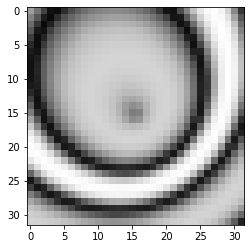

In [3]:
na=[[1,0,0,1,0,0,0,0],
   [1,1,0,1,0,0,0,0],
   [1,0,1,1,0,0,0,0],
   [1,0,0,1,0,0,0,0],
   [0,0,0,0,0,1,0,0],
   [0,0,0,0,1,0,1,0],
   [0,0,0,1,1,1,1,1],
   [0,0,0,1,0,0,0,1]]
im = PIL.Image.open("simple.png")
im1=im.convert("L").resize((pixels,pixels))
goal=(np.array(im1))
im.close()
plt.imshow(goal, cmap='Greys_r',vmin=0, vmax=255)

In [4]:
grad_goal = np.gradient(goal)
test=np.stack([goal,grad_goal[0],grad_goal[1]])
print(test.shape)

(3, 32, 32)


In [5]:
def my_sigmoid(in_):
    return 1/(1 + np.exp(-in_))

In [6]:
def get_feature_sets(im):
    grad = np.gradient(im)
    feats=np.stack([im,grad[0],grad[1]])
    #for i in range(3):
        #mean = np.mean(feats[i])
        #std = np.std(feats[i])
        #feats[i]=(feats[i]-mean)/std
    return feats
goal_feats = get_feature_sets(goal)

In [7]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((pixels,pixels))     
        for i in range(pixels*pixels):
            myPic[i%pixels][int(i/pixels)] = net.activate(x[i%pixels][int(i/pixels)])[0]
        myPic = np.clip(myPic, -1, 1)
        myPic=255*(1-np.abs(myPic))
        genome.pic = myPic
        genome.fitness = ((np.square(goal-myPic)).mean()-(255*255))/((-255*255))*100

In [8]:
archive = []
archive_len = 0
def eval_genomes_me(genomes, config):
    global archive, archive_len
    temp_ar = []
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((pixels,pixels))     
        for i in range(pixels*pixels):
            myPic[i%pixels][int(i/pixels)] = net.activate(x[i%pixels][int(i/pixels)])[0]
        myPic = np.clip(myPic, -1, 1)
        myPic=255*(1-np.abs(myPic))
        genome.pic = myPic
        genome.bc0 = sum(genome.size())
        temp_ar.append((genome_id,genome))
        genome.fitness = ((np.square(goal-myPic)).mean()-(255*255))/((-255*255))*100
    bc1s=test_encode(encoder, decoder, device, temp_ar, loss_fn)
    for i,genome in enumerate(temp_ar):
        genome[1].bc1 = bc1s[i]
    if archive_len < 3000:
        archive_len += len(temp_ar)
        archive.extend(temp_ar)
    else:
        for genome in temp_ar:
            archive[archive_len%len(archive)]
            archive_len += 1

In [9]:
def eval_genomes_other(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((pixels,pixels))     
        for i in range(pixels*pixels):
            myPic[i%pixels][int(i/pixels)] = net.activate(x[i%pixels][int(i/pixels)])[0]
        myPic = np.clip(myPic, -1, 1)
        myPic=255*(1-np.abs(myPic))
        genome.pic = myPic
        fit = np.exp(np.abs(goal-myPic)*-3)
        fit=np.nan_to_num(fit)
        fit= 1-fit
        fit = np.mean(fit)
        genome.fitness = (1-np.square(fit))*100

In [10]:
def eval_genomes_new_fit(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((32,32,1))     
        for i in range(32*32):
            myPic[i%32][int(i/32)] = net.activate(x[i%32][int(i/32)])
        myPic = np.squeeze(np.clip(myPic, -1, 1))
        myPic=255*(1-np.abs(myPic))
        my_feats = get_feature_sets(myPic)
        genome.pic = myPic
        fit = np.exp(np.abs(goal_feats-myPic)*-5)
        fit=np.nan_to_num(fit)
        fit= 1-fit
        fit = np.mean(fit)
        genome.fitness = (1-np.square(fit))*100

In [11]:
#not changed to new standard
def eval_genomes_alt(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((32,32,1))     
        for i in range(32*32):
            myPic[i%32][int(i/32)] = net.activate(x[i%32][int(i/32)])
        myPic = my_sigmoid(myPic)
        genome.pic = myPic
        genome.fitness = ((np.abs(goal-myPic)<.05).sum())/((32*32))*100

In [12]:
class speciateElites(neat.DefaultSpeciesSet):
    
    def __init__(self, config, reporters):
        super().__init__(config, reporters)
        self.map_elites = {}
        self.max_loss=.01
        self.min_loss=.0
        self.first = True
        
    @classmethod
    def parse_config(cls, param_dict):
        return neat.config.DefaultClassConfig(param_dict,
                                  [neat.config.ConfigParameter('compatibility_threshold', float),
                                   neat.config.ConfigParameter('map_size', tuple, (32, 32)),
                                   neat.config.ConfigParameter('complexity_range', int, 100),])

    def speciate(self, config, population, generation):
        """
        Place genomes into species by genetic similarity.
        Note that this method assumes the current representatives of the species are from the old
        generation, and that after speciation has been performed, the old representatives should be
        dropped and replaced with representatives from the new generation.  If you violate this
        assumption, you should make sure other necessary parts of the code are updated to reflect
        the new behavior.
        """
        assert isinstance(population, dict)

        compatibility_threshold = self.species_set_config.compatibility_threshold
        unspeciated = set(population)
        
        #fill map of elites
        self.fill_elites(population.items())
        
        # Find the best representatives for each existing species.
        unspeciated = set(population)
        distances = neat.species.GenomeDistanceCache(config.genome_config)
        new_representatives = {}
        new_members = {}
        for sid, s in self.species.items():
            candidates = []
            for gid in unspeciated:
                g = population[gid]
                d = distances(s.representative, g)
                candidates.append((d, g))

            # The new representative is the genome closest to the current representative.
            ignored_rdist, new_rep = min(candidates, key=lambda x: x[0])
            new_rid = new_rep.key
            new_representatives[sid] = new_rep
            new_members[sid] = [new_rid]
            unspeciated.remove(new_rid)

        # Partition population into species based on genetic similarity.
        while unspeciated:
            gid = unspeciated.pop()
            g = population[gid]

            # Find the species with the most similar representative.
            candidates = []
            for sid, rep in new_representatives.items():
                d = distances(rep, g)
                if d < compatibility_threshold:
                    candidates.append((d, sid))

            if candidates:
                ignored_sdist, sid = min(candidates, key=lambda x: x[0])
                new_members[sid].append(gid)
            else:
                # No species is similar enough, create a new species, using
                # this genome as its representative.
                sid = next(self.indexer)
                new_representatives[sid] = g
                new_members[sid] = [gid]
        
        
        # Partition elites into species based on genetic similarity.
        for gid, g in self.map_elites.values():

            # Find the species with the most similar representative.
            candidates = []
            for sid, rep in new_representatives.items():
                d = distances(rep, g)                
                candidates.append((d, sid))

            
            ignored_sdist, sid = min(candidates, key=lambda x: x[0])
            #easy change if you want elites to be able breed with other elites
            #new_members[sid].append(gid)
            g.sid = sid
            
            
                


        # Update species collection based on new speciation.
        self.genome_to_species = {}
        for sid, rep in new_representatives.items():
            s = self.species.get(sid)
            if s is None:
                s = neat.species.Species(sid, generation)
                self.species[sid] = s

            members = new_members[sid]
            for gid in members:
                self.genome_to_species[gid] = sid

            member_dict = dict((gid, population[gid]) for gid in members)
            s.update(rep, member_dict)

        gdmean = neat.math_util.mean(distances.distances.values())
        gdstdev = neat.math_util.stdev(distances.distances.values())
        self.reporters.info(
            'Mean genetic distance {0:.3f}, standard deviation {1:.3f}'.format(gdmean, gdstdev))
        cov = len(self.map_elites)*100/(self.species_set_config.map_size[0]*self.species_set_config.map_size[1])
        self.reporters.info(f"Archive_coverage = {cov:.3f}%")
        
    def fill_elites(self, to_fill):
        
        map_size = self.species_set_config.map_size
        bc_range = ((0,self.species_set_config.complexity_range),(self.min_loss, self.max_loss))
        for my_ind in to_fill:
            adjusted_bc0=math.ceil((my_ind[1].bc0-bc_range[0][0])/(bc_range[0][1]-bc_range[0][0])*map_size[0])-1
            adjusted_bc1=math.ceil((my_ind[1].bc1-bc_range[1][0])/(bc_range[1][1]-bc_range[1][0])*map_size[1])-1
            
            if adjusted_bc0>map_size[0]-1:
                adjusted_bc0 = map_size[0]-1
            elif adjusted_bc0<0:
                adjusted_bc0 =0
                
            if adjusted_bc1>map_size[1]-1:
                adjusted_bc1 = map_size[1]-1
            elif adjusted_bc1<0:
                adjusted_bc1 =0 
                
            key =adjusted_bc0*map_size[1] + adjusted_bc1
            if key in self.map_elites:
                if self.map_elites[key][1].fitness<my_ind[1].fitness:
                    my_ind[1].me_key=key
                    self.map_elites[key]=my_ind
            else:
                my_ind[1].me_key=key
                self.map_elites[key]=my_ind

In [17]:
class mapElites(neat.DefaultReproduction):
    
    def __init__(self, config, reporters, stagnation):
        super().__init__(config, reporters, stagnation)
    
    def reproduce(self, config, species, pop_size, generation):
        all_fitnesses = []
        remaining_species = []
        for stag_sid, stag_s, stagnant in self.stagnation.update(species, generation):
            if stagnant:
                self.reporters.species_stagnant(stag_sid, stag_s)
            else:
                all_fitnesses.extend(m.fitness for m in stag_s.members.values())
                remaining_species.append(stag_s)
        
        if not remaining_species:
            species.species = {}
            return {}
        
        remaining_species_dict = {}
        species.species={}
        for s in remaining_species:
            old_members=list(s.members.items())
            repro_cutoff = int(math.ceil(self.reproduction_config.survival_threshold *
                                         len(old_members)))
            old_members = list(s.members.items())
            old_members.sort(reverse=True, key=lambda x: x[1].fitness)
            remaining_species_dict[s.key] = (old_members[:repro_cutoff],s)
            
            
        a_list=[*species.map_elites.values()]
        num_babies=150
        new_population ={}
        i=0
        while i < num_babies:    
            parentA=random.choice(a_list)
            if parentA[1].sid in remaining_species_dict:
                gid = next(self.genome_indexer)
                child = config.genome_type(gid)
                b_pool, s = remaining_species_dict[parentA[1].sid]
                parentB=random.choice(b_pool)
                child.configure_crossover(parentA[1], parentB[1], config.genome_config)
                species.species[s.key]=s
                child.mutate(config.genome_config)
                new_population[gid] = child
                self.ancestors[gid] = (parentA[0], parentB[0])
                i+=1
            #if species went extinct remove elite
            else:
                map_elites.pop(parentA[1].me_key)
                a_list=[*species.map_elites.values()]
                
                
        return new_population

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, stride=2, 
            padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, 
            padding=1, output_padding=0)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [14]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
encoder.float()
decoder.float()
def train_epoch_den(encoder, decoder, device, archive, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in archive: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = torch.from_numpy(image_batch[1].pic).squeeze().expand(1,1,-1,-1).float()
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.min(train_loss), np.max(train_loss)

def test_encode(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        losses = np.empty(len(dataloader))
        for i, image_batch in enumerate(dataloader):
            # Move tensor to the proper device
            image_batch = torch.from_numpy(image_batch[1].pic).squeeze().expand(1,1,-1,-1).float()
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            losses[i]=loss_fn(decoded_data.cpu(), image_batch.cpu())
    return losses

Selected device: cpu


In [27]:
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-new')
#add cosine
def cos(x):
    return math.cos(x)

config.genome_config.activation_defs.add('cos', cos)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes_other,10000)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
myPic = np.empty((pixels,pixels,1))      
for i in range(pixels*pixels): 
    myPic[i%pixels][int(i/pixels)] = winner_net.activate(x[i%pixels][int(i/pixels)])
myPic = np.clip(myPic, -1, 1)
myPic=255*(1-np.abs(myPic))
plt.imshow(myPic, cmap='Greys_r',vmin=0, vmax=255)


 ****** Running generation 0 ****** 

Population's average fitness: 0.20972 stdev: 0.28435
Best fitness: 1.28186 - size: (9, 33) - species 133 - id 133
Average adjusted fitness: 0.164
Mean genetic distance 3.929, standard deviation 0.316
Population of 300 members in 150 species
Total extinctions: 0
Generation time: 6.739 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.20894 stdev: 0.27440
Best fitness: 1.42985 - size: (9, 32) - species 15 - id 212
Average adjusted fitness: 0.146
Mean genetic distance 3.872, standard deviation 0.286
Population of 300 members in 152 species
Total extinctions: 0
Generation time: 11.502 sec (9.121 average)

 ****** Running generation 2 ****** 



KeyboardInterrupt: 

In [15]:
class ME_Pop(neat.Population):
    def __init__(self, config, initial_state=None):
        self.reporters = neat.reporting.ReporterSet()
        self.config = config
        stagnation = config.stagnation_type(config.stagnation_config, self.reporters)
        self.reproduction = config.reproduction_type(config.reproduction_config,
                                                     self.reporters,
                                                     stagnation)
        if config.fitness_criterion == 'max':
            self.fitness_criterion = max
        elif config.fitness_criterion == 'min':
            self.fitness_criterion = min
        elif config.fitness_criterion == 'mean':
            self.fitness_criterion = neat.math_util.mean
        elif not config.no_fitness_termination:
            raise RuntimeError(
                "Unexpected fitness_criterion: {0!r}".format(config.fitness_criterion))

        if initial_state is None:
            # Create a population from scratch, then partition into species.
            self.population = self.reproduction.create_new(config.genome_type,
                                                           config.genome_config,
                                                           config.pop_size)
            self.species = config.species_set_type(config.species_set_config, self.reporters)
            self.generation = 0
        else:
            self.population, self.species, self.generation = initial_state

        self.best_genome = None

    def run(self, fitness_function, n=None):
        """
        Runs NEAT's genetic algorithm for at most n generations.  If n
        is None, run until solution is found or extinction occurs.
        The user-provided fitness_function must take only two arguments:
            1. The population as a list of (genome id, genome) tuples.
            2. The current configuration object.
        The return value of the fitness function is ignored, but it must assign
        a Python float to the `fitness` member of each genome.
        The fitness function is free to maintain external state, perform
        evaluations in parallel, etc.
        It is assumed that fitness_function does not modify the list of genomes,
        the genomes themselves (apart from updating the fitness member),
        or the configuration object.
        """

        if self.config.no_fitness_termination and (n is None):
            raise RuntimeError("Cannot have no generational limit with no fitness termination")

        k = 0
        while n is None or k < n:
            k += 1

            self.reporters.start_generation(self.generation)

            # Evaluate all genomes using the user-provided function.
            fitness_function(list(self.population.items()), self.config)
            
            # Divide the new population into species.
            self.species.speciate(self.config, self.population, self.generation)

            # Gather and report statistics.
            best = None
            for g in self.population.values():
                if g.fitness is None:
                    raise RuntimeError("Fitness not assigned to genome {}".format(g.key))

                if best is None or g.fitness > best.fitness:
                    best = g
            self.reporters.post_evaluate(self.config, self.population, self.species, best)

            # Track the best genome ever seen.
            if self.best_genome is None or best.fitness > self.best_genome.fitness:
                self.best_genome = best

            if not self.config.no_fitness_termination:
                # End if the fitness threshold is reached.
                fv = self.fitness_criterion(g.fitness for g in self.population.values())
                if fv >= self.config.fitness_threshold:
                    self.reporters.found_solution(self.config, self.generation, best)
                    break

            # Create the next generation from the current generation.
            self.population = self.reproduction.reproduce(self.config, self.species,
                                                          self.config.pop_size, self.generation)

            # Check for complete extinction.
            if not self.species.species:
                self.reporters.complete_extinction()

                # If requested by the user, create a completely new population,
                # otherwise raise an exception.
                if self.config.reset_on_extinction:
                    self.population = self.reproduction.create_new(self.config.genome_type,
                                                                   self.config.genome_config,
                                                                   self.config.pop_size)
                else:
                    raise CompleteExtinctionException()

            self.reporters.end_generation(self.config, self.population, self.species)

            self.generation += 1

        if self.config.no_fitness_termination:
            self.reporters.found_solution(self.config, self.generation, self.best_genome)

        return self.best_genome

In [ ]:
# MAP ELITES VERSION
# Load configuration.
config = neat.Config(neat.DefaultGenome, mapElites,
                     speciateElites, neat.DefaultStagnation,
                     'config-me-spec')
#add cosine
def cos(x):
    return math.cos(x)

config.genome_config.activation_defs.add('cos', cos)

# Create the population, which is the top-level object for a NEAT run.
p = ME_Pop(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

winner = p.run(eval_genomes_me,5)
for i in range(10):
# Run until a solution is found.
    max_loss = 0
    print('training autoencoder')
    for i in range(150):
        if i%15 == 0:
            print('.',end='')
        min_loss, max_loss = train_epoch_den(encoder, decoder, device, archive, loss_fn, optim)
    print('\nfinished autoencoder')
    p.species.max_loss=max_loss
    p.species.min_loss=min_loss
    old_elites=p.species.map_elites.values()
    p.species.map_elites = {}
    bc1s=test_encode(encoder, decoder, device, archive, loss_fn)
    for i,genome in enumerate(archive):
        genome[1].bc1 = bc1s[i]
    bc1s=test_encode(encoder, decoder, device, old_elites, loss_fn)
    for i,genome in enumerate(old_elites):
        genome[1].bc1 = bc1s[i]
    p.species.fill_elites(old_elites)
    p.species.fill_elites(archive)
    winner = p.run(eval_genomes_me,1000)
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
myPic = np.empty((pixels,pixels,1))      
for i in range(pixels*pixels): 
    myPic[i%pixels][int(i/pixels)] = winner_net.activate(x[i%pixels][int(i/pixels)])
myPic = np.clip(myPic, -1, 1)
myPic=255*(1-np.abs(myPic))
plt.imshow(myPic, cmap='Greys_r',vmin=0, vmax=255)


 ****** Running generation 0 ****** 

Mean genetic distance 4.051, standard deviation 0.157
Archive_coverage = 0.098%
Population's average fitness: 74.67431 stdev: 6.62795
Best fitness: 89.34015 - size: (9, 33) - species 2 - id 14
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.253 sec

 ****** Running generation 1 ****** 

Mean genetic distance 2.772, standard deviation 1.129
Archive_coverage = 0.391%
Population's average fitness: 84.17445 stdev: 6.41438
Best fitness: 92.67177 - size: (10, 33) - species 2 - id 154
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.630 sec (4.942 average)

 ****** Running generation 2 ****** 

Mean genetic distance 2.314, standard deviation 0.419
Archive_coverage = 0.488%
Population's average fitness: 84.82932 stdev: 5.88185
Best fitness: 92.80306 - size: (8, 30) - species 2 - id 304
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.541 sec (4.808 average)

 ******

Mean genetic distance 3.008, standard deviation 0.771
Archive_coverage = 36.816%
Population's average fitness: 83.07244 stdev: 8.66198
Best fitness: 93.66998 - size: (6, 17) - species 13 - id 3605
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 5.027 sec (4.688 average)

 ****** Running generation 25 ****** 

Mean genetic distance 2.937, standard deviation 0.743
Archive_coverage = 37.109%
Population's average fitness: 81.97534 stdev: 8.86564
Best fitness: 93.65562 - size: (4, 9) - species 13 - id 3860
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 4.869 sec (4.744 average)

 ****** Running generation 26 ****** 

Mean genetic distance 3.091, standard deviation 0.640
Archive_coverage = 37.500%
Population's average fitness: 81.47211 stdev: 9.02624
Best fitness: 93.65562 - size: (4, 7) - species 13 - id 3958
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 4.525 sec (4.747 average)

 ****** Running gener

Mean genetic distance 2.952, standard deviation 0.758
Archive_coverage = 45.410%
Population's average fitness: 82.64705 stdev: 8.54937
Best fitness: 93.65582 - size: (5, 14) - species 15 - id 7456
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 4.496 sec (4.702 average)

 ****** Running generation 50 ****** 

Mean genetic distance 3.081, standard deviation 0.679
Archive_coverage = 45.801%
Population's average fitness: 81.54569 stdev: 8.59364
Best fitness: 93.65582 - size: (17, 39) - species 12 - id 7521
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 4.660 sec (4.693 average)

 ****** Running generation 51 ****** 

Mean genetic distance 3.360, standard deviation 0.645
Archive_coverage = 45.996%
Population's average fitness: 83.06740 stdev: 9.01675
Best fitness: 93.65582 - size: (17, 39) - species 15 - id 7667
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 5.115 sec (4.714 average)

 ****** Running g

Mean genetic distance 2.978, standard deviation 0.590
Archive_coverage = 52.051%
Population's average fitness: 83.48094 stdev: 8.88218
Best fitness: 93.65585 - size: (19, 42) - species 15 - id 11182
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.107 sec (4.896 average)

 ****** Running generation 75 ****** 

Mean genetic distance 2.979, standard deviation 0.629
Archive_coverage = 52.344%
Population's average fitness: 81.28422 stdev: 9.18104
Best fitness: 93.65582 - size: (7, 17) - species 14 - id 11286
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.049 sec (4.913 average)

 ****** Running generation 76 ****** 

Mean genetic distance 2.993, standard deviation 0.653
Archive_coverage = 52.344%
Population's average fitness: 82.07984 stdev: 9.00653
Best fitness: 93.65585 - size: (8, 18) - species 14 - id 11542
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 4.827 sec (4.888 average)

 ****** Running

Mean genetic distance 2.755, standard deviation 0.654
Archive_coverage = 55.957%
Population's average fitness: 81.72719 stdev: 9.04863
Best fitness: 93.64348 - size: (13, 35) - species 21 - id 14759
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 5.447 sec (5.313 average)

 ****** Running generation 99 ****** 

Mean genetic distance 2.999, standard deviation 0.670
Archive_coverage = 56.348%
Population's average fitness: 82.39376 stdev: 9.68767
Best fitness: 93.65584 - size: (11, 21) - species 19 - id 14993
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.774 sec (5.391 average)

 ****** Running generation 100 ****** 

Mean genetic distance 2.696, standard deviation 0.624
Archive_coverage = 56.348%
Population's average fitness: 82.99052 stdev: 8.97241
Best fitness: 93.99312 - size: (6, 13) - species 21 - id 15008
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.407 sec (5.421 average)

 ****** Runni

Mean genetic distance 2.737, standard deviation 0.729
Archive_coverage = 58.496%
Population's average fitness: 81.79046 stdev: 8.83172
Best fitness: 93.65004 - size: (12, 33) - species 22 - id 18364
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 4.856 sec (5.326 average)

 ****** Running generation 123 ****** 

Mean genetic distance 2.726, standard deviation 0.642
Archive_coverage = 58.691%
Population's average fitness: 82.67954 stdev: 8.49744
Best fitness: 93.65584 - size: (11, 22) - species 25 - id 18534
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.297 sec (5.342 average)

 ****** Running generation 124 ****** 

Mean genetic distance 2.831, standard deviation 0.699
Archive_coverage = 58.691%
Population's average fitness: 82.64315 stdev: 9.04655
Best fitness: 93.65473 - size: (13, 34) - species 27 - id 18707
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.270 sec (5.334 average)

 ****** Run

Mean genetic distance 3.168, standard deviation 0.628
Archive_coverage = 62.402%
Population's average fitness: 82.38506 stdev: 8.56531
Best fitness: 93.65573 - size: (23, 42) - species 33 - id 22042
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.655 sec (5.854 average)

 ****** Running generation 147 ****** 

Mean genetic distance 2.312, standard deviation 0.564
Archive_coverage = 62.500%
Population's average fitness: 81.57474 stdev: 9.24269
Best fitness: 93.65554 - size: (9, 24) - species 27 - id 22172
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.690 sec (5.824 average)

 ****** Running generation 148 ****** 

Mean genetic distance 2.630, standard deviation 0.603
Archive_coverage = 62.793%
Population's average fitness: 83.11678 stdev: 8.74919
Best fitness: 93.65176 - size: (9, 26) - species 33 - id 22273
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.330 sec (5.760 average)

 ****** Runni

Mean genetic distance 2.714, standard deviation 0.797
Archive_coverage = 65.723%
Population's average fitness: 81.77225 stdev: 8.93204
Best fitness: 93.65118 - size: (2, 2) - species 33 - id 25596
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.605 sec (5.312 average)

 ****** Running generation 171 ****** 

Mean genetic distance 2.452, standard deviation 0.520
Archive_coverage = 65.723%
Population's average fitness: 82.92612 stdev: 8.81338
Best fitness: 93.83918 - size: (2, 1) - species 33 - id 25744
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.644 sec (5.364 average)

 ****** Running generation 172 ****** 

Mean genetic distance 2.519, standard deviation 0.423
Archive_coverage = 65.820%
Population's average fitness: 81.81736 stdev: 9.11481
Best fitness: 93.65583 - size: (9, 22) - species 34 - id 25891
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.283 sec (5.362 average)

 ****** Running 

Mean genetic distance 2.948, standard deviation 0.646
Archive_coverage = 68.457%
Population's average fitness: 83.51068 stdev: 8.87808
Best fitness: 93.65455 - size: (11, 28) - species 33 - id 29206
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.008 sec (6.005 average)

 ****** Running generation 195 ****** 

Mean genetic distance 3.102, standard deviation 0.639
Archive_coverage = 68.750%
Population's average fitness: 82.34815 stdev: 8.79695
Best fitness: 93.65573 - size: (23, 47) - species 33 - id 29393
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.909 sec (5.979 average)

 ****** Running generation 196 ****** 

Mean genetic distance 2.325, standard deviation 0.520
Archive_coverage = 68.848%
Population's average fitness: 80.37856 stdev: 9.05753
Best fitness: 93.65448 - size: (3, 5) - species 34 - id 29480
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.180 sec (5.973 average)

 ****** Runni

Mean genetic distance 2.877, standard deviation 0.752
Archive_coverage = 70.410%
Population's average fitness: 82.35482 stdev: 8.77910
Best fitness: 93.66610 - size: (23, 42) - species 50 - id 32721
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.658 sec (6.043 average)

 ****** Running generation 219 ****** 

Mean genetic distance 2.599, standard deviation 0.706
Archive_coverage = 70.410%
Population's average fitness: 82.02342 stdev: 8.95472
Best fitness: 93.65595 - size: (22, 38) - species 40 - id 32875
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.649 sec (6.123 average)

 ****** Running generation 220 ****** 

Mean genetic distance 3.052, standard deviation 0.753
Archive_coverage = 70.410%
Population's average fitness: 82.63167 stdev: 9.01050
Best fitness: 93.65573 - size: (21, 35) - species 50 - id 33004
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.775 sec (6.225 average)

 ****** Run

Mean genetic distance 2.375, standard deviation 0.431
Archive_coverage = 74.609%
Population's average fitness: 82.27017 stdev: 8.86222
Best fitness: 93.79862 - size: (11, 24) - species 53 - id 36443
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.436 sec (6.235 average)

 ****** Running generation 243 ****** 

Mean genetic distance 3.178, standard deviation 0.687
Archive_coverage = 75.000%
Population's average fitness: 81.83489 stdev: 8.58691
Best fitness: 93.65469 - size: (30, 58) - species 52 - id 36475
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.232 sec (6.218 average)

 ****** Running generation 244 ****** 

Mean genetic distance 2.693, standard deviation 0.689
Archive_coverage = 75.195%
Population's average fitness: 80.98306 stdev: 8.71956
Best fitness: 93.65584 - size: (11, 24) - species 53 - id 36659
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.135 sec (6.211 average)

 ****** Run

Mean genetic distance 2.451, standard deviation 0.475
Archive_coverage = 80.371%
Population's average fitness: 82.06942 stdev: 8.89253
Best fitness: 93.65283 - size: (12, 32) - species 40 - id 39954
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.152 sec (5.796 average)

 ****** Running generation 267 ****** 

Mean genetic distance 3.127, standard deviation 0.735
Archive_coverage = 80.371%
Population's average fitness: 82.11899 stdev: 8.88034
Best fitness: 93.65706 - size: (13, 33) - species 65 - id 40123
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.276 sec (5.818 average)

 ****** Running generation 268 ****** 

Mean genetic distance 2.763, standard deviation 0.768
Archive_coverage = 80.664%
Population's average fitness: 81.92833 stdev: 9.02477
Best fitness: 93.65573 - size: (23, 45) - species 66 - id 40332
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.174 sec (5.886 average)

 ****** Run

Mean genetic distance 2.928, standard deviation 0.810
Archive_coverage = 83.008%
Population's average fitness: 81.20544 stdev: 8.99841
Best fitness: 93.65584 - size: (11, 22) - species 64 - id 43647
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.111 sec (5.749 average)

 ****** Running generation 291 ****** 

Mean genetic distance 2.740, standard deviation 0.903
Archive_coverage = 83.008%
Population's average fitness: 81.81339 stdev: 8.75503
Best fitness: 93.65584 - size: (11, 22) - species 64 - id 43693
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.927 sec (5.772 average)

 ****** Running generation 292 ****** 

Mean genetic distance 2.470, standard deviation 0.535
Archive_coverage = 83.105%
Population's average fitness: 81.49700 stdev: 9.23538
Best fitness: 93.66390 - size: (27, 41) - species 40 - id 43929
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.480 sec (5.733 average)

 ****** Run

Mean genetic distance 2.763, standard deviation 0.760
Archive_coverage = 86.133%
Population's average fitness: 81.12955 stdev: 8.95419
Best fitness: 93.64618 - size: (23, 44) - species 74 - id 47195
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.832 sec (6.173 average)

 ****** Running generation 315 ****** 

Mean genetic distance 2.698, standard deviation 0.823
Archive_coverage = 86.133%
Population's average fitness: 81.27195 stdev: 8.80005
Best fitness: 93.54888 - size: (23, 44) - species 76 - id 47261
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.833 sec (6.114 average)

 ****** Running generation 316 ****** 

Mean genetic distance 2.496, standard deviation 0.554
Archive_coverage = 86.230%
Population's average fitness: 80.10057 stdev: 9.10422
Best fitness: 93.65207 - size: (2, 2) - species 76 - id 47455
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.591 sec (6.017 average)

 ****** Runni

Mean genetic distance 3.033, standard deviation 0.741
Archive_coverage = 88.965%
Population's average fitness: 82.32019 stdev: 9.00265
Best fitness: 93.65584 - size: (19, 42) - species 74 - id 50849
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.967 sec (6.089 average)

 ****** Running generation 339 ****** 

Mean genetic distance 3.132, standard deviation 0.695
Archive_coverage = 88.965%
Population's average fitness: 81.03740 stdev: 9.47674
Best fitness: 93.65581 - size: (33, 60) - species 74 - id 50854
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.204 sec (6.139 average)

 ****** Running generation 340 ****** 

Mean genetic distance 3.144, standard deviation 0.691
Archive_coverage = 88.965%
Population's average fitness: 80.71468 stdev: 9.26800
Best fitness: 93.65522 - size: (16, 35) - species 74 - id 51063
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.522 sec (6.179 average)

 ****** Run

Mean genetic distance 2.513, standard deviation 0.507
Archive_coverage = 90.820%
Population's average fitness: 81.25932 stdev: 9.49223
Best fitness: 93.64880 - size: (24, 51) - species 74 - id 54347
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.317 sec (6.308 average)

 ****** Running generation 363 ****** 

Mean genetic distance 2.244, standard deviation 0.383
Archive_coverage = 91.113%
Population's average fitness: 82.86273 stdev: 8.67937
Best fitness: 93.64687 - size: (11, 30) - species 89 - id 54526
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.801 sec (6.247 average)

 ****** Running generation 364 ****** 

Mean genetic distance 2.510, standard deviation 0.454
Archive_coverage = 91.113%
Population's average fitness: 82.50892 stdev: 8.98293
Best fitness: 93.64618 - size: (23, 40) - species 74 - id 54707
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.236 sec (6.223 average)

 ****** Run

Mean genetic distance 2.979, standard deviation 0.742
Archive_coverage = 92.480%
Population's average fitness: 81.89268 stdev: 8.65565
Best fitness: 93.65379 - size: (37, 77) - species 74 - id 57995
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.766 sec (6.340 average)

 ****** Running generation 387 ****** 

Mean genetic distance 2.907, standard deviation 0.807
Archive_coverage = 92.676%
Population's average fitness: 81.97884 stdev: 8.95504
Best fitness: 93.65396 - size: (4, 5) - species 91 - id 58153
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.433 sec (6.389 average)

 ****** Running generation 388 ****** 

Mean genetic distance 2.893, standard deviation 0.719
Archive_coverage = 92.773%
Population's average fitness: 82.29041 stdev: 8.46488
Best fitness: 93.64640 - size: (37, 66) - species 91 - id 58249
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.215 sec (6.376 average)

 ****** Runni

Mean genetic distance 2.949, standard deviation 0.873
Archive_coverage = 94.141%
Population's average fitness: 83.15205 stdev: 8.62028
Best fitness: 94.02564 - size: (6, 17) - species 91 - id 61637
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.466 sec (6.609 average)

 ****** Running generation 411 ****** 

Mean genetic distance 2.723, standard deviation 0.775
Archive_coverage = 94.238%
Population's average fitness: 81.25240 stdev: 8.94497
Best fitness: 93.65274 - size: (35, 60) - species 101 - id 61788
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.093 sec (6.565 average)

 ****** Running generation 412 ****** 

Mean genetic distance 2.714, standard deviation 0.769
Archive_coverage = 94.238%
Population's average fitness: 81.23027 stdev: 9.31658
Best fitness: 93.83918 - size: (2, 1) - species 101 - id 61934
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.778 sec (6.572 average)

 ****** Runn

Mean genetic distance 2.789, standard deviation 0.754
Archive_coverage = 95.801%
Population's average fitness: 82.30474 stdev: 8.51404
Best fitness: 93.82382 - size: (1, 2) - species 108 - id 65213
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.194 sec (6.748 average)

 ****** Running generation 435 ****** 

Mean genetic distance 2.686, standard deviation 0.640
Archive_coverage = 95.801%
Population's average fitness: 81.83717 stdev: 8.80042
Best fitness: 93.64612 - size: (23, 39) - species 105 - id 65344
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.567 sec (6.675 average)

 ****** Running generation 436 ****** 

Mean genetic distance 2.902, standard deviation 0.774
Archive_coverage = 95.801%
Population's average fitness: 79.42815 stdev: 9.31206
Best fitness: 93.64629 - size: (21, 38) - species 108 - id 65438
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.271 sec (6.614 average)

 ****** Ru

Mean genetic distance 2.456, standard deviation 0.560
Archive_coverage = 96.875%
Population's average fitness: 82.90270 stdev: 8.44724
Best fitness: 93.65251 - size: (32, 63) - species 109 - id 68818
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.977 sec (6.121 average)

 ****** Running generation 459 ****** 

Mean genetic distance 2.077, standard deviation 0.233
Archive_coverage = 96.973%
Population's average fitness: 81.59796 stdev: 8.89469
Best fitness: 94.16260 - size: (3, 9) - species 109 - id 68852
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.718 sec (6.080 average)

 ****** Running generation 460 ****** 

Mean genetic distance 2.243, standard deviation 0.314
Archive_coverage = 96.973%
Population's average fitness: 82.25258 stdev: 9.36885
Best fitness: 93.68211 - size: (39, 77) - species 109 - id 69045
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.684 sec (5.999 average)

 ****** Ru

Mean genetic distance 2.642, standard deviation 0.773
Archive_coverage = 97.656%
Population's average fitness: 81.09033 stdev: 9.00938
Best fitness: 93.65447 - size: (4, 6) - species 133 - id 72373
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 7.135 sec (6.790 average)

 ****** Running generation 483 ****** 

Mean genetic distance 2.921, standard deviation 0.779
Archive_coverage = 97.754%
Population's average fitness: 82.08565 stdev: 8.72611
Best fitness: 93.65493 - size: (15, 34) - species 122 - id 72573
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 7.171 sec (6.861 average)

 ****** Running generation 484 ****** 

Mean genetic distance 3.210, standard deviation 0.714
Archive_coverage = 97.852%
Population's average fitness: 82.59553 stdev: 8.80733
Best fitness: 93.74255 - size: (7, 16) - species 136 - id 72701
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 7.041 sec (6.920 average)

 ****** Run

Mean genetic distance 2.357, standard deviation 0.443
Archive_coverage = 98.438%
Population's average fitness: 81.61880 stdev: 8.81518
Best fitness: 93.61316 - size: (41, 81) - species 138 - id 75919
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.767 sec (6.246 average)

 ****** Running generation 507 ****** 

Mean genetic distance 2.372, standard deviation 0.436
Archive_coverage = 98.438%
Population's average fitness: 81.86706 stdev: 8.64446
Best fitness: 93.66807 - size: (18, 37) - species 138 - id 76104
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.160 sec (6.213 average)

 ****** Running generation 508 ****** 

Mean genetic distance 2.680, standard deviation 0.800
Archive_coverage = 98.438%
Population's average fitness: 81.35339 stdev: 9.08497
Best fitness: 93.65344 - size: (2, 2) - species 137 - id 76345
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.079 sec (6.198 average)

 ****** Ru

Mean genetic distance 2.984, standard deviation 0.724
Archive_coverage = 98.730%
Population's average fitness: 80.62230 stdev: 8.83961
Best fitness: 93.65573 - size: (21, 41) - species 137 - id 79572
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.352 sec (6.288 average)

 ****** Running generation 531 ****** 

Mean genetic distance 2.659, standard deviation 0.556
Archive_coverage = 98.730%
Population's average fitness: 80.43928 stdev: 9.22349
Best fitness: 93.62702 - size: (13, 30) - species 138 - id 79732
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.852 sec (6.365 average)

 ****** Running generation 532 ****** 

Mean genetic distance 2.875, standard deviation 0.812
Archive_coverage = 98.730%
Population's average fitness: 82.26530 stdev: 8.52347
Best fitness: 93.61316 - size: (37, 75) - species 137 - id 79908
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.465 sec (6.447 average)

 ****** 

Mean genetic distance 2.968, standard deviation 0.775
Archive_coverage = 99.219%
Population's average fitness: 83.05433 stdev: 9.02573
Best fitness: 93.70546 - size: (4, 5) - species 153 - id 83205
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.954 sec (6.855 average)

 ****** Running generation 555 ****** 

Mean genetic distance 2.945, standard deviation 0.858
Archive_coverage = 99.219%
Population's average fitness: 81.96560 stdev: 9.52019
Best fitness: 93.65510 - size: (24, 41) - species 151 - id 83314
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.524 sec (6.860 average)

 ****** Running generation 556 ****** 

Mean genetic distance 2.798, standard deviation 0.817
Archive_coverage = 99.219%
Population's average fitness: 82.27667 stdev: 8.98380
Best fitness: 93.71558 - size: (4, 8) - species 151 - id 83529
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.195 sec (6.786 average)

 ****** Runn

Mean genetic distance 2.287, standard deviation 0.497
Archive_coverage = 99.316%
Population's average fitness: 83.02697 stdev: 8.95838
Best fitness: 93.65745 - size: (7, 17) - species 157 - id 86769
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.675 sec (6.399 average)

 ****** Running generation 579 ****** 

Mean genetic distance 2.944, standard deviation 0.579
Archive_coverage = 99.414%
Population's average fitness: 82.45622 stdev: 9.25248
Best fitness: 93.67037 - size: (22, 37) - species 157 - id 86970
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.392 sec (6.407 average)

 ****** Running generation 580 ****** 

Mean genetic distance 3.190, standard deviation 0.650
Archive_coverage = 99.414%
Population's average fitness: 80.88917 stdev: 9.38872
Best fitness: 93.65612 - size: (39, 75) - species 153 - id 87048
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 7.274 sec (6.521 average)

 ****** R

Mean genetic distance 2.717, standard deviation 0.761
Archive_coverage = 99.609%
Population's average fitness: 82.28826 stdev: 9.13230
Best fitness: 93.64838 - size: (9, 26) - species 161 - id 90426
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 7.007 sec (6.972 average)

 ****** Running generation 603 ****** 

Mean genetic distance 3.033, standard deviation 0.888
Archive_coverage = 99.609%
Population's average fitness: 81.12026 stdev: 9.18505
Best fitness: 93.64838 - size: (9, 24) - species 157 - id 90535
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.575 sec (6.987 average)

 ****** Running generation 604 ****** 

Mean genetic distance 3.114, standard deviation 0.900
Archive_coverage = 99.609%
Population's average fitness: 81.54491 stdev: 8.96367
Best fitness: 93.66065 - size: (30, 58) - species 162 - id 90739
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 7.051 sec (7.001 average)

 ****** Ru

Mean genetic distance 2.877, standard deviation 0.809
Archive_coverage = 99.707%
Population's average fitness: 82.76778 stdev: 8.76042
Best fitness: 93.65578 - size: (23, 43) - species 184 - id 94014
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 7.490 sec (7.194 average)

 ****** Running generation 627 ****** 

Mean genetic distance 2.754, standard deviation 0.734
Archive_coverage = 99.707%
Population's average fitness: 81.49008 stdev: 9.25264
Best fitness: 93.65912 - size: (6, 14) - species 182 - id 94110
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 7.041 sec (7.229 average)

 ****** Running generation 628 ****** 

Mean genetic distance 2.934, standard deviation 0.851
Archive_coverage = 99.707%
Population's average fitness: 81.65770 stdev: 9.24942
Best fitness: 93.66624 - size: (11, 27) - species 179 - id 94287
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.345 sec (7.174 average)

 ****** R

Mean genetic distance 2.866, standard deviation 0.812
Archive_coverage = 99.805%
Population's average fitness: 80.79006 stdev: 9.33729
Best fitness: 93.64561 - size: (12, 29) - species 200 - id 97529
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.747 sec (6.463 average)

 ****** Running generation 651 ****** 

Mean genetic distance 2.900, standard deviation 0.841
Archive_coverage = 99.805%
Population's average fitness: 82.07954 stdev: 8.93167
Best fitness: 93.64494 - size: (13, 28) - species 200 - id 97655
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.194 sec (6.480 average)

 ****** Running generation 652 ****** 

Mean genetic distance 2.343, standard deviation 0.460
Archive_coverage = 99.805%
Population's average fitness: 80.79581 stdev: 8.86694
Best fitness: 93.69201 - size: (23, 43) - species 199 - id 97879
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.674 sec (6.453 average)

 ****** 

Mean genetic distance 2.651, standard deviation 0.688
Archive_coverage = 99.902%
Population's average fitness: 81.27874 stdev: 8.70385
Best fitness: 93.64027 - size: (41, 79) - species 202 - id 101240
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.738 sec (6.661 average)

 ****** Running generation 675 ****** 

Mean genetic distance 2.528, standard deviation 0.499
Archive_coverage = 99.902%
Population's average fitness: 82.64358 stdev: 8.18516
Best fitness: 93.64027 - size: (41, 80) - species 201 - id 101269
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.724 sec (6.678 average)

 ****** Running generation 676 ****** 

Mean genetic distance 2.154, standard deviation 0.337
Archive_coverage = 99.902%
Population's average fitness: 82.16312 stdev: 8.66694
Best fitness: 93.65004 - size: (13, 35) - species 201 - id 101506
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.867 sec (6.705 average)

 ****

Mean genetic distance 2.894, standard deviation 0.918
Archive_coverage = 99.902%
Population's average fitness: 81.63660 stdev: 9.14921
Best fitness: 93.93277 - size: (6, 14) - species 226 - id 104777
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 7.017 sec (7.032 average)

 ****** Running generation 699 ****** 

Mean genetic distance 2.786, standard deviation 0.837
Archive_coverage = 99.902%
Population's average fitness: 81.81297 stdev: 9.46989
Best fitness: 93.65599 - size: (8, 19) - species 227 - id 104958
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 7.065 sec (7.048 average)

 ****** Running generation 700 ****** 

Mean genetic distance 3.109, standard deviation 0.769
Archive_coverage = 99.902%
Population's average fitness: 81.21673 stdev: 9.15033
Best fitness: 93.64476 - size: (25, 39) - species 225 - id 105105
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.507 sec (7.041 average)

 ******

Mean genetic distance 2.802, standard deviation 0.526
Archive_coverage = 100.000%
Population's average fitness: 81.75418 stdev: 9.14042
Best fitness: 93.65573 - size: (22, 38) - species 225 - id 108370
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.407 sec (6.664 average)

 ****** Running generation 723 ****** 

Mean genetic distance 2.452, standard deviation 0.488
Archive_coverage = 100.000%
Population's average fitness: 81.95836 stdev: 8.85630
Best fitness: 93.65173 - size: (29, 54) - species 231 - id 108525
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.388 sec (6.610 average)

 ****** Running generation 724 ****** 

Mean genetic distance 2.651, standard deviation 0.519
Archive_coverage = 100.000%
Population's average fitness: 81.02102 stdev: 9.17351
Best fitness: 93.68838 - size: (4, 10) - species 237 - id 108679
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.488 sec (6.503 average)

 **

Mean genetic distance 2.926, standard deviation 0.849
Archive_coverage = 100.000%
Population's average fitness: 81.45374 stdev: 8.77341
Best fitness: 93.64214 - size: (37, 71) - species 248 - id 112048
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 7.494 sec (7.023 average)

 ****** Running generation 747 ****** 

Mean genetic distance 2.576, standard deviation 0.665
Archive_coverage = 100.000%
Population's average fitness: 82.17937 stdev: 8.29565
Best fitness: 93.69339 - size: (11, 30) - species 243 - id 112161
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.722 sec (7.060 average)

 ****** Running generation 748 ****** 

Mean genetic distance 2.708, standard deviation 0.574
Archive_coverage = 100.000%
Population's average fitness: 81.31641 stdev: 8.86825
Best fitness: 93.74673 - size: (13, 30) - species 249 - id 112340
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.934 sec (7.026 average)

 *

Mean genetic distance 3.097, standard deviation 0.890
Archive_coverage = 100.000%
Population's average fitness: 80.91594 stdev: 9.06052
Best fitness: 93.68331 - size: (13, 36) - species 252 - id 115617
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.329 sec (6.723 average)

 ****** Running generation 771 ****** 

Mean genetic distance 2.955, standard deviation 0.802
Archive_coverage = 100.000%
Population's average fitness: 82.01649 stdev: 8.20887
Best fitness: 93.85252 - size: (22, 35) - species 257 - id 115663
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.385 sec (6.675 average)

 ****** Running generation 772 ****** 

Mean genetic distance 2.684, standard deviation 0.783
Archive_coverage = 100.000%
Population's average fitness: 81.81183 stdev: 9.17448
Best fitness: 93.61313 - size: (37, 72) - species 248 - id 115927
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.303 sec (6.685 average)

 *

Mean genetic distance 2.717, standard deviation 0.644
Archive_coverage = 100.000%
Population's average fitness: 80.98027 stdev: 8.53133
Best fitness: 93.84876 - size: (36, 70) - species 260 - id 119224
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.126 sec (6.345 average)

 ****** Running generation 795 ****** 

Mean genetic distance 2.774, standard deviation 0.836
Archive_coverage = 100.000%
Population's average fitness: 80.99347 stdev: 9.53155
Best fitness: 93.65562 - size: (4, 9) - species 260 - id 119366
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.117 sec (6.297 average)

 ****** Running generation 796 ****** 

Mean genetic distance 2.531, standard deviation 0.588
Archive_coverage = 100.000%
Population's average fitness: 82.10562 stdev: 8.90028
Best fitness: 93.65161 - size: (22, 33) - species 260 - id 119490
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.690 sec (6.271 average)

 ***

Mean genetic distance 2.422, standard deviation 0.492
Archive_coverage = 100.000%
Population's average fitness: 81.18277 stdev: 9.07689
Best fitness: 93.67020 - size: (19, 37) - species 262 - id 122850
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 7.211 sec (6.382 average)

 ****** Running generation 819 ****** 

Mean genetic distance 2.184, standard deviation 0.334
Archive_coverage = 100.000%
Population's average fitness: 81.13025 stdev: 9.21567
Best fitness: 93.65523 - size: (33, 66) - species 262 - id 122962
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 7.296 sec (6.471 average)

 ****** Running generation 820 ****** 

Mean genetic distance 2.313, standard deviation 0.375
Archive_coverage = 100.000%
Population's average fitness: 80.65001 stdev: 8.96200
Best fitness: 93.65424 - size: (13, 32) - species 262 - id 123142
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.876 sec (6.550 average)

 *

Mean genetic distance 2.648, standard deviation 0.717
Archive_coverage = 100.000%
Population's average fitness: 81.64751 stdev: 8.48851
Best fitness: 93.61424 - size: (3, 5) - species 279 - id 126439
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.209 sec (6.788 average)

 ****** Running generation 843 ****** 

Mean genetic distance 3.071, standard deviation 0.673
Archive_coverage = 100.000%
Population's average fitness: 81.33352 stdev: 8.83347
Best fitness: 93.70033 - size: (11, 27) - species 279 - id 126527
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.385 sec (6.779 average)

 ****** Running generation 844 ****** 

Mean genetic distance 2.943, standard deviation 0.720
Archive_coverage = 100.000%
Population's average fitness: 80.75631 stdev: 8.51408
Best fitness: 94.02803 - size: (6, 17) - species 270 - id 126693
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.984 sec (6.755 average)

 ****

Mean genetic distance 2.855, standard deviation 0.528
Archive_coverage = 100.000%
Population's average fitness: 82.32185 stdev: 9.01360
Best fitness: 93.65243 - size: (8, 17) - species 270 - id 129955
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.099 sec (6.160 average)

 ****** Running generation 867 ****** 

Mean genetic distance 2.852, standard deviation 0.519
Archive_coverage = 100.000%
Population's average fitness: 82.43260 stdev: 9.23596
Best fitness: 93.65640 - size: (5, 14) - species 285 - id 130122
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.524 sec (6.096 average)

 ****** Running generation 868 ****** 

Mean genetic distance 2.895, standard deviation 0.831
Archive_coverage = 100.000%
Population's average fitness: 82.33092 stdev: 9.34104
Best fitness: 93.65584 - size: (41, 84) - species 279 - id 130337
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.289 sec (6.076 average)

 ***

Mean genetic distance 2.674, standard deviation 0.595
Archive_coverage = 100.000%
Population's average fitness: 81.24675 stdev: 8.94538
Best fitness: 93.65294 - size: (23, 44) - species 286 - id 133547
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.671 sec (6.504 average)

 ****** Running generation 891 ****** 

Mean genetic distance 2.731, standard deviation 0.714
Archive_coverage = 100.000%
Population's average fitness: 81.77336 stdev: 9.00852
Best fitness: 93.65502 - size: (23, 44) - species 279 - id 133791
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.527 sec (6.530 average)

 ****** Running generation 892 ****** 

Mean genetic distance 2.443, standard deviation 0.555
Archive_coverage = 100.000%
Population's average fitness: 81.08564 stdev: 9.25416
Best fitness: 93.95777 - size: (7, 13) - species 286 - id 133858
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.642 sec (6.559 average)

 **

Mean genetic distance 2.897, standard deviation 0.814
Archive_coverage = 100.000%
Population's average fitness: 80.80509 stdev: 9.07799
Best fitness: 93.65584 - size: (40, 79) - species 308 - id 137210
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 7.675 sec (6.863 average)

 ****** Running generation 915 ****** 

Mean genetic distance 2.981, standard deviation 0.829
Archive_coverage = 100.000%
Population's average fitness: 82.30773 stdev: 8.66451
Best fitness: 93.64838 - size: (36, 72) - species 296 - id 137340
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 7.670 sec (6.977 average)

 ****** Running generation 916 ****** 

Mean genetic distance 3.144, standard deviation 0.754
Archive_coverage = 100.000%
Population's average fitness: 80.69641 stdev: 8.99761
Best fitness: 93.64027 - size: (38, 67) - species 302 - id 137489
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 7.027 sec (6.986 average)

 *

Mean genetic distance 2.911, standard deviation 0.789
Archive_coverage = 100.000%
Population's average fitness: 81.54681 stdev: 9.75420
Best fitness: 93.81492 - size: (2, 1) - species 322 - id 140842
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 7.201 sec (6.885 average)

 ****** Running generation 939 ****** 

Mean genetic distance 2.536, standard deviation 0.728
Archive_coverage = 100.000%
Population's average fitness: 82.60191 stdev: 8.78907
Best fitness: 93.65004 - size: (12, 28) - species 323 - id 140876
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.687 sec (6.891 average)

 ****** Running generation 940 ****** 

Mean genetic distance 2.528, standard deviation 0.580
Archive_coverage = 100.000%
Population's average fitness: 82.49776 stdev: 9.14765
Best fitness: 93.65541 - size: (39, 74) - species 323 - id 141134
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.469 sec (6.902 average)

 ***

Mean genetic distance 2.759, standard deviation 0.767
Archive_coverage = 100.000%
Population's average fitness: 81.22534 stdev: 9.30241
Best fitness: 93.65584 - size: (40, 80) - species 326 - id 144333
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.913 sec (6.676 average)

 ****** Running generation 963 ****** 

Mean genetic distance 2.804, standard deviation 0.810
Archive_coverage = 100.000%
Population's average fitness: 81.52964 stdev: 9.10709
Best fitness: 93.63352 - size: (44, 85) - species 334 - id 144485
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.594 sec (6.671 average)

 ****** Running generation 964 ****** 

Mean genetic distance 2.316, standard deviation 0.476
Archive_coverage = 100.000%
Population's average fitness: 81.13931 stdev: 9.08477
Best fitness: 93.65244 - size: (6, 18) - species 334 - id 144748
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.226 sec (6.609 average)

 **

Mean genetic distance 2.779, standard deviation 0.855
Archive_coverage = 100.000%
Population's average fitness: 81.76920 stdev: 9.17535
Best fitness: 93.63436 - size: (29, 54) - species 348 - id 148050
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.144 sec (6.490 average)

 ****** Running generation 987 ****** 

Mean genetic distance 3.002, standard deviation 0.770
Archive_coverage = 100.000%
Population's average fitness: 80.84960 stdev: 8.54573
Best fitness: 93.63220 - size: (30, 59) - species 348 - id 148151
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 7.033 sec (6.485 average)

 ****** Running generation 988 ****** 

Mean genetic distance 2.843, standard deviation 0.864
Archive_coverage = 100.000%
Population's average fitness: 79.74852 stdev: 9.33413
Best fitness: 93.91061 - size: (30, 58) - species 348 - id 148228
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.756 sec (6.417 average)

 *

Mean genetic distance 2.594, standard deviation 0.583
Archive_coverage = 100.000%
Population's average fitness: 81.34720 stdev: 8.61370
Best fitness: 93.65563 - size: (14, 36) - species 326 - id 151606
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.531 sec (6.346 average)

 ****** Running generation 1011 ****** 

Mean genetic distance 2.174, standard deviation 0.314
Archive_coverage = 100.000%
Population's average fitness: 80.61132 stdev: 8.99855
Best fitness: 93.64545 - size: (20, 29) - species 349 - id 151775
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.173 sec (6.306 average)

 ****** Running generation 1012 ****** 

Mean genetic distance 2.872, standard deviation 0.811
Archive_coverage = 100.000%
Population's average fitness: 81.56193 stdev: 8.66759
Best fitness: 93.64599 - size: (5, 9) - species 326 - id 151917
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.151 sec (6.216 average)

 *

Mean genetic distance 2.916, standard deviation 0.883
Archive_coverage = 100.000%
Population's average fitness: 82.30703 stdev: 8.47810
Best fitness: 93.64827 - size: (12, 23) - species 379 - id 155146
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.966 sec (6.898 average)

 ****** Running generation 1035 ****** 

Mean genetic distance 2.666, standard deviation 0.883
Archive_coverage = 100.000%
Population's average fitness: 81.81786 stdev: 9.38161
Best fitness: 93.64127 - size: (12, 23) - species 379 - id 155304
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.497 sec (6.825 average)

 ****** Running generation 1036 ****** 

Mean genetic distance 2.404, standard deviation 0.538
Archive_coverage = 100.000%
Population's average fitness: 81.56744 stdev: 9.80150
Best fitness: 93.64488 - size: (13, 34) - species 373 - id 155412
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.986 sec (6.813 average)



Mean genetic distance 2.630, standard deviation 0.544
Archive_coverage = 100.000%
Population's average fitness: 81.26427 stdev: 9.01126
Best fitness: 93.67912 - size: (11, 22) - species 383 - id 158766
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.494 sec (6.424 average)

 ****** Running generation 1059 ****** 

Mean genetic distance 2.263, standard deviation 0.379
Archive_coverage = 100.000%
Population's average fitness: 81.29940 stdev: 8.64602
Best fitness: 93.65506 - size: (13, 35) - species 388 - id 158993
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.025 sec (6.356 average)

 ****** Running generation 1060 ****** 

Mean genetic distance 2.348, standard deviation 0.413
Archive_coverage = 100.000%
Population's average fitness: 83.56856 stdev: 8.32748
Best fitness: 93.65523 - size: (33, 59) - species 383 - id 159079
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.428 sec (6.396 average)



Mean genetic distance 3.252, standard deviation 0.816
Archive_coverage = 100.000%
Population's average fitness: 80.54319 stdev: 9.08736
Best fitness: 93.60602 - size: (36, 66) - species 399 - id 162347
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.454 sec (6.574 average)

 ****** Running generation 1083 ****** 

Mean genetic distance 2.704, standard deviation 0.763
Archive_coverage = 100.000%
Population's average fitness: 80.49106 stdev: 8.55778
Best fitness: 93.90869 - size: (2, 2) - species 399 - id 162558
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.420 sec (6.486 average)

 ****** Running generation 1084 ****** 

Mean genetic distance 2.822, standard deviation 0.835
Archive_coverage = 100.000%
Population's average fitness: 81.22706 stdev: 8.98563
Best fitness: 93.91491 - size: (2, 2) - species 399 - id 162736
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.366 sec (6.440 average)

 ***

Mean genetic distance 3.248, standard deviation 0.778
Archive_coverage = 100.000%
Population's average fitness: 81.73224 stdev: 8.85768
Best fitness: 93.65384 - size: (40, 82) - species 401 - id 165971
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.052 sec (6.172 average)

 ****** Running generation 1107 ****** 

Mean genetic distance 2.931, standard deviation 0.782
Archive_coverage = 100.000%
Population's average fitness: 80.49593 stdev: 8.57214
Best fitness: 93.65485 - size: (10, 16) - species 399 - id 166083
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.316 sec (6.189 average)

 ****** Running generation 1108 ****** 

Mean genetic distance 2.871, standard deviation 0.770
Archive_coverage = 100.000%
Population's average fitness: 80.92832 stdev: 9.07616
Best fitness: 93.64019 - size: (33, 59) - species 401 - id 166232
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.792 sec (6.070 average)



Mean genetic distance 2.820, standard deviation 0.749
Archive_coverage = 100.000%
Population's average fitness: 80.52785 stdev: 9.17875
Best fitness: 93.64866 - size: (12, 23) - species 413 - id 169649
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.495 sec (6.379 average)

 ****** Running generation 1131 ****** 

Mean genetic distance 2.684, standard deviation 0.620
Archive_coverage = 100.000%
Population's average fitness: 81.99283 stdev: 8.40705
Best fitness: 93.64866 - size: (12, 22) - species 403 - id 169769
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.131 sec (6.282 average)

 ****** Running generation 1132 ****** 

Mean genetic distance 2.827, standard deviation 0.716
Archive_coverage = 100.000%
Population's average fitness: 81.36712 stdev: 9.20814
Best fitness: 94.13604 - size: (7, 13) - species 401 - id 169920
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.056 sec (6.307 average)

 

Mean genetic distance 2.619, standard deviation 0.716
Archive_coverage = 100.000%
Population's average fitness: 80.97214 stdev: 8.97338
Best fitness: 93.65573 - size: (23, 38) - species 413 - id 173218
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.940 sec (6.381 average)

 ****** Running generation 1155 ****** 

Mean genetic distance 2.422, standard deviation 0.501
Archive_coverage = 100.000%
Population's average fitness: 81.46934 stdev: 8.81346
Best fitness: 93.59897 - size: (6, 13) - species 415 - id 173393
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.831 sec (6.339 average)

 ****** Running generation 1156 ****** 

Mean genetic distance 2.565, standard deviation 0.722
Archive_coverage = 100.000%
Population's average fitness: 81.71876 stdev: 8.78553
Best fitness: 93.65304 - size: (28, 47) - species 413 - id 173426
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.956 sec (6.278 average)

 

Mean genetic distance 2.697, standard deviation 0.842
Archive_coverage = 100.000%
Population's average fitness: 81.27072 stdev: 8.42412
Best fitness: 93.61385 - size: (22, 43) - species 428 - id 176706
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.712 sec (6.105 average)

 ****** Running generation 1179 ****** 

Mean genetic distance 2.506, standard deviation 0.612
Archive_coverage = 100.000%
Population's average fitness: 80.25713 stdev: 8.37144
Best fitness: 93.93200 - size: (7, 14) - species 424 - id 176943
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.656 sec (6.024 average)

 ****** Running generation 1180 ****** 

Mean genetic distance 2.465, standard deviation 0.561
Archive_coverage = 100.000%
Population's average fitness: 82.80099 stdev: 8.39992
Best fitness: 93.65584 - size: (41, 77) - species 424 - id 177052
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.016 sec (6.008 average)

 

Mean genetic distance 2.952, standard deviation 0.862
Archive_coverage = 100.000%
Population's average fitness: 81.05575 stdev: 8.70509
Best fitness: 93.94116 - size: (13, 30) - species 445 - id 180420
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 5.933 sec (6.678 average)

 ****** Running generation 1203 ****** 

Mean genetic distance 2.859, standard deviation 0.799
Archive_coverage = 100.000%
Population's average fitness: 81.34307 stdev: 9.00551
Best fitness: 93.65581 - size: (37, 70) - species 436 - id 180492
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.633 sec (6.692 average)

 ****** Running generation 1204 ****** 

Mean genetic distance 2.504, standard deviation 0.628
Archive_coverage = 100.000%
Population's average fitness: 82.06156 stdev: 8.24878
Best fitness: 93.84574 - size: (5, 10) - species 424 - id 180661
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.515 sec (6.686 average)

 

Mean genetic distance 2.497, standard deviation 0.480
Archive_coverage = 100.000%
Population's average fitness: 82.44732 stdev: 8.63177
Best fitness: 93.65520 - size: (23, 42) - species 445 - id 183915
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.633 sec (6.366 average)

 ****** Running generation 1227 ****** 

Mean genetic distance 2.826, standard deviation 0.533
Archive_coverage = 100.000%
Population's average fitness: 82.19372 stdev: 9.37738
Best fitness: 93.65803 - size: (26, 47) - species 436 - id 184169
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.918 sec (6.334 average)

 ****** Running generation 1228 ****** 

Mean genetic distance 2.592, standard deviation 0.753
Archive_coverage = 100.000%
Population's average fitness: 81.44471 stdev: 8.86822
Best fitness: 93.65748 - size: (11, 25) - species 448 - id 184295
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.105 sec (6.297 average)



Mean genetic distance 3.030, standard deviation 0.804
Archive_coverage = 100.000%
Population's average fitness: 81.50782 stdev: 8.74228
Best fitness: 93.65584 - size: (29, 47) - species 450 - id 187531
Population of 150 members in 9 species
Total extinctions: 0
Generation time: 7.117 sec (6.415 average)

 ****** Running generation 1251 ****** 

Mean genetic distance 2.837, standard deviation 0.836
Archive_coverage = 100.000%
Population's average fitness: 81.17880 stdev: 9.69249
Best fitness: 93.66563 - size: (40, 71) - species 449 - id 187795
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.604 sec (6.460 average)

 ****** Running generation 1252 ****** 

Mean genetic distance 2.858, standard deviation 0.809
Archive_coverage = 100.000%
Population's average fitness: 81.80141 stdev: 9.32129
Best fitness: 93.65666 - size: (17, 32) - species 452 - id 187928
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.771 sec (6.521 average)



Mean genetic distance 2.711, standard deviation 0.708
Archive_coverage = 100.000%
Population's average fitness: 79.01417 stdev: 9.00721
Best fitness: 93.65415 - size: (33, 63) - species 461 - id 191209
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.018 sec (6.401 average)

 ****** Running generation 1275 ****** 

Mean genetic distance 2.804, standard deviation 0.746
Archive_coverage = 100.000%
Population's average fitness: 80.16593 stdev: 8.00540
Best fitness: 93.65415 - size: (24, 46) - species 463 - id 191375
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.931 sec (6.312 average)

 ****** Running generation 1276 ****** 

Mean genetic distance 2.334, standard deviation 0.472
Archive_coverage = 100.000%
Population's average fitness: 80.95048 stdev: 8.85073
Best fitness: 93.66008 - size: (5, 9) - species 461 - id 191424
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.773 sec (6.223 average)

 *

Mean genetic distance 3.458, standard deviation 0.804
Archive_coverage = 100.000%
Population's average fitness: 81.66502 stdev: 8.84300
Best fitness: 93.64842 - size: (16, 29) - species 465 - id 194754
Population of 150 members in 9 species
Total extinctions: 0
Generation time: 6.717 sec (6.604 average)

 ****** Running generation 1299 ****** 

Mean genetic distance 2.677, standard deviation 0.764
Archive_coverage = 100.000%
Population's average fitness: 82.37760 stdev: 9.09538
Best fitness: 93.65766 - size: (16, 27) - species 491 - id 194989
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.423 sec (6.486 average)

 ****** Running generation 1300 ****** 

Mean genetic distance 2.715, standard deviation 0.755
Archive_coverage = 100.000%
Population's average fitness: 80.99046 stdev: 8.99302
Best fitness: 93.64027 - size: (7, 17) - species 491 - id 195063
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.128 sec (6.418 average)

 

Mean genetic distance 3.049, standard deviation 0.782
Archive_coverage = 100.000%
Population's average fitness: 83.09202 stdev: 8.98221
Best fitness: 93.76935 - size: (3, 9) - species 503 - id 198318
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.424 sec (6.648 average)

 ****** Running generation 1323 ****** 

Mean genetic distance 2.673, standard deviation 0.705
Archive_coverage = 100.000%
Population's average fitness: 81.78390 stdev: 9.08336
Best fitness: 93.64027 - size: (23, 36) - species 501 - id 198553
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.967 sec (6.616 average)

 ****** Running generation 1324 ****** 

Mean genetic distance 2.813, standard deviation 0.760
Archive_coverage = 100.000%
Population's average fitness: 80.79656 stdev: 8.12466
Best fitness: 93.65249 - size: (22, 43) - species 503 - id 198658
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.782 sec (6.469 average)

 *

Mean genetic distance 2.859, standard deviation 0.818
Archive_coverage = 100.000%
Population's average fitness: 81.49072 stdev: 8.59226
Best fitness: 93.65549 - size: (32, 63) - species 518 - id 202018
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.110 sec (5.977 average)

 ****** Running generation 1347 ****** 

Mean genetic distance 2.618, standard deviation 0.866
Archive_coverage = 100.000%
Population's average fitness: 81.25318 stdev: 8.93916
Best fitness: 93.64055 - size: (39, 74) - species 518 - id 202122
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.195 sec (6.042 average)

 ****** Running generation 1348 ****** 

Mean genetic distance 2.589, standard deviation 0.838
Archive_coverage = 100.000%
Population's average fitness: 81.95359 stdev: 8.59952
Best fitness: 93.64711 - size: (5, 11) - species 518 - id 202285
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.989 sec (6.057 average)

 

Mean genetic distance 3.151, standard deviation 0.722
Archive_coverage = 100.000%
Population's average fitness: 82.11336 stdev: 8.79805
Best fitness: 93.57123 - size: (2, 6) - species 518 - id 205640
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.287 sec (6.276 average)

 ****** Running generation 1371 ****** 

Mean genetic distance 2.828, standard deviation 0.751
Archive_coverage = 100.000%
Population's average fitness: 81.44920 stdev: 8.70594
Best fitness: 93.63567 - size: (3, 5) - species 518 - id 205782
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.767 sec (6.230 average)

 ****** Running generation 1372 ****** 

Mean genetic distance 2.211, standard deviation 0.405
Archive_coverage = 100.000%
Population's average fitness: 80.94586 stdev: 8.50077
Best fitness: 93.63523 - size: (3, 5) - species 518 - id 205875
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.845 sec (6.214 average)

 *****

Mean genetic distance 2.298, standard deviation 0.508
Archive_coverage = 100.000%
Population's average fitness: 81.59408 stdev: 9.09064
Best fitness: 93.56244 - size: (2, 4) - species 525 - id 209229
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.400 sec (6.303 average)

 ****** Running generation 1395 ****** 

Mean genetic distance 3.401, standard deviation 0.761
Archive_coverage = 100.000%
Population's average fitness: 81.39280 stdev: 9.11862
Best fitness: 94.02001 - size: (7, 14) - species 537 - id 209387
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.795 sec (6.394 average)

 ****** Running generation 1396 ****** 

Mean genetic distance 2.621, standard deviation 0.755
Archive_coverage = 100.000%
Population's average fitness: 81.23508 stdev: 8.83252
Best fitness: 93.65004 - size: (14, 35) - species 534 - id 209443
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.459 sec (6.425 average)

 **

Mean genetic distance 2.991, standard deviation 0.835
Archive_coverage = 100.000%
Population's average fitness: 80.97092 stdev: 8.62608
Best fitness: 93.65581 - size: (37, 69) - species 543 - id 212828
Population of 150 members in 11 species
Total extinctions: 0
Generation time: 7.579 sec (6.600 average)

 ****** Running generation 1419 ****** 

Mean genetic distance 2.744, standard deviation 0.706
Archive_coverage = 100.000%
Population's average fitness: 80.87693 stdev: 8.74648
Best fitness: 93.65466 - size: (23, 39) - species 541 - id 212918
Population of 150 members in 10 species
Total extinctions: 0
Generation time: 7.097 sec (6.589 average)

 ****** Running generation 1420 ****** 

Mean genetic distance 2.839, standard deviation 0.760
Archive_coverage = 100.000%
Population's average fitness: 81.69937 stdev: 8.83972
Best fitness: 93.65466 - size: (22, 39) - species 542 - id 213096
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.652 sec (6.507 average)

Mean genetic distance 3.044, standard deviation 0.835
Archive_coverage = 100.000%
Population's average fitness: 82.54116 stdev: 8.49185
Best fitness: 93.78397 - size: (8, 19) - species 548 - id 216435
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.414 sec (6.320 average)

 ****** Running generation 1443 ****** 

Mean genetic distance 2.790, standard deviation 0.816
Archive_coverage = 100.000%
Population's average fitness: 81.75306 stdev: 8.99908
Best fitness: 93.62962 - size: (22, 34) - species 551 - id 216502
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.181 sec (6.340 average)

 ****** Running generation 1444 ****** 

Mean genetic distance 3.108, standard deviation 0.781
Archive_coverage = 100.000%
Population's average fitness: 81.82523 stdev: 8.86694
Best fitness: 93.64481 - size: (12, 32) - species 551 - id 216619
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.166 sec (6.272 average)

 

Mean genetic distance 2.805, standard deviation 0.825
Archive_coverage = 100.000%
Population's average fitness: 81.39925 stdev: 8.84736
Best fitness: 93.65476 - size: (22, 33) - species 551 - id 219957
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.555 sec (6.217 average)

 ****** Running generation 1467 ****** 

Mean genetic distance 3.193, standard deviation 0.831
Archive_coverage = 100.000%
Population's average fitness: 80.15856 stdev: 8.93632
Best fitness: 93.66627 - size: (23, 38) - species 556 - id 220190
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.116 sec (6.271 average)

 ****** Running generation 1468 ****** 

Mean genetic distance 2.847, standard deviation 0.798
Archive_coverage = 100.000%
Population's average fitness: 79.99337 stdev: 8.24267
Best fitness: 93.63866 - size: (30, 56) - species 559 - id 220202
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.160 sec (6.306 average)



Mean genetic distance 2.755, standard deviation 0.659
Archive_coverage = 100.000%
Population's average fitness: 81.14865 stdev: 9.35072
Best fitness: 93.66250 - size: (16, 41) - species 561 - id 223575
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.930 sec (6.204 average)

 ****** Running generation 1491 ****** 

Mean genetic distance 3.214, standard deviation 0.634
Archive_coverage = 100.000%
Population's average fitness: 81.50160 stdev: 9.40497
Best fitness: 93.61159 - size: (8, 18) - species 561 - id 223673
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.415 sec (6.170 average)

 ****** Running generation 1492 ****** 

Mean genetic distance 2.871, standard deviation 0.860
Archive_coverage = 100.000%
Population's average fitness: 81.76539 stdev: 8.81317
Best fitness: 93.60513 - size: (22, 32) - species 563 - id 223895
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.362 sec (6.134 average)

 

Mean genetic distance 2.618, standard deviation 0.514
Archive_coverage = 100.000%
Population's average fitness: 80.51474 stdev: 9.43466
Best fitness: 93.65620 - size: (10, 22) - species 571 - id 227222
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.278 sec (5.889 average)

 ****** Running generation 1515 ****** 

Mean genetic distance 3.368, standard deviation 0.814
Archive_coverage = 100.000%
Population's average fitness: 80.97802 stdev: 9.17170
Best fitness: 93.65334 - size: (33, 51) - species 577 - id 227297
Population of 150 members in 11 species
Total extinctions: 0
Generation time: 6.595 sec (5.896 average)

 ****** Running generation 1516 ****** 

Mean genetic distance 2.656, standard deviation 0.650
Archive_coverage = 100.000%
Population's average fitness: 82.41995 stdev: 8.96329
Best fitness: 93.73198 - size: (2, 3) - species 573 - id 227453
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.608 sec (5.905 average)

 

Mean genetic distance 2.431, standard deviation 0.480
Archive_coverage = 100.000%
Population's average fitness: 80.43263 stdev: 8.64521
Best fitness: 93.83211 - size: (2, 2) - species 575 - id 230833
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.059 sec (6.456 average)

 ****** Running generation 1539 ****** 

Mean genetic distance 2.826, standard deviation 0.746
Archive_coverage = 100.000%
Population's average fitness: 80.70553 stdev: 8.84049
Best fitness: 93.61495 - size: (36, 65) - species 588 - id 230859
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.948 sec (6.270 average)

 ****** Running generation 1540 ****** 

Mean genetic distance 3.004, standard deviation 0.731
Archive_coverage = 100.000%
Population's average fitness: 81.87262 stdev: 9.03017
Best fitness: 93.77253 - size: (2, 2) - species 588 - id 231130
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.952 sec (6.214 average)

 ***

Mean genetic distance 2.624, standard deviation 0.667
Archive_coverage = 100.000%
Population's average fitness: 81.16536 stdev: 8.86317
Best fitness: 93.65573 - size: (30, 56) - species 599 - id 234402
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.784 sec (6.176 average)

 ****** Running generation 1563 ****** 

Mean genetic distance 2.352, standard deviation 0.501
Archive_coverage = 100.000%
Population's average fitness: 82.34145 stdev: 8.98510
Best fitness: 93.83907 - size: (2, 1) - species 575 - id 234543
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.651 sec (6.101 average)

 ****** Running generation 1564 ****** 

Mean genetic distance 2.887, standard deviation 0.813
Archive_coverage = 100.000%
Population's average fitness: 81.77956 stdev: 8.96752
Best fitness: 93.64346 - size: (4, 6) - species 599 - id 234680
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.068 sec (6.078 average)

 ***

Mean genetic distance 2.719, standard deviation 0.839
Archive_coverage = 100.000%
Population's average fitness: 81.74538 stdev: 8.82365
Best fitness: 93.65327 - size: (39, 66) - species 612 - id 237910
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.849 sec (6.084 average)

 ****** Running generation 1587 ****** 

Mean genetic distance 2.316, standard deviation 0.464
Archive_coverage = 100.000%
Population's average fitness: 81.15530 stdev: 8.71917
Best fitness: 93.77126 - size: (21, 35) - species 614 - id 238142
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.839 sec (6.089 average)

 ****** Running generation 1588 ****** 

Mean genetic distance 2.286, standard deviation 0.369
Archive_coverage = 100.000%
Population's average fitness: 80.77799 stdev: 8.34115
Best fitness: 93.65286 - size: (33, 66) - species 614 - id 238219
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.203 sec (6.102 average)



Mean genetic distance 2.800, standard deviation 0.820
Archive_coverage = 100.000%
Population's average fitness: 81.60180 stdev: 8.67479
Best fitness: 93.68697 - size: (4, 9) - species 632 - id 241638
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.493 sec (6.198 average)

 ****** Running generation 1611 ****** 

Mean genetic distance 2.994, standard deviation 0.883
Archive_coverage = 100.000%
Population's average fitness: 83.41673 stdev: 8.83669
Best fitness: 93.70506 - size: (5, 9) - species 645 - id 241692
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.001 sec (6.139 average)

 ****** Running generation 1612 ****** 

Mean genetic distance 2.784, standard deviation 0.718
Archive_coverage = 100.000%
Population's average fitness: 81.18141 stdev: 9.37465
Best fitness: 93.66047 - size: (11, 20) - species 632 - id 241946
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.578 sec (6.112 average)

 ***

Mean genetic distance 2.205, standard deviation 0.349
Archive_coverage = 100.000%
Population's average fitness: 81.18260 stdev: 9.26982
Best fitness: 93.64364 - size: (11, 28) - species 649 - id 245110
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.666 sec (6.176 average)

 ****** Running generation 1635 ****** 

Mean genetic distance 2.213, standard deviation 0.366
Archive_coverage = 100.000%
Population's average fitness: 81.15157 stdev: 9.18540
Best fitness: 93.65573 - size: (23, 41) - species 649 - id 245372
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.887 sec (6.117 average)

 ****** Running generation 1636 ****** 

Mean genetic distance 2.331, standard deviation 0.473
Archive_coverage = 100.000%
Population's average fitness: 81.04098 stdev: 8.98635
Best fitness: 93.65563 - size: (22, 35) - species 649 - id 245466
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.230 sec (6.092 average)



Mean genetic distance 3.053, standard deviation 0.769
Archive_coverage = 100.000%
Population's average fitness: 82.62579 stdev: 9.15693
Best fitness: 93.69171 - size: (7, 17) - species 656 - id 248740
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.069 sec (5.895 average)

 ****** Running generation 1659 ****** 

Mean genetic distance 2.712, standard deviation 0.707
Archive_coverage = 100.000%
Population's average fitness: 81.52517 stdev: 9.20225
Best fitness: 93.65100 - size: (36, 63) - species 662 - id 248942
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.078 sec (5.905 average)

 ****** Running generation 1660 ****** 

Mean genetic distance 3.038, standard deviation 0.732
Archive_coverage = 100.000%
Population's average fitness: 82.55991 stdev: 8.95670
Best fitness: 93.90700 - size: (8, 14) - species 658 - id 249121
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.266 sec (5.945 average)

 *

Mean genetic distance 2.757, standard deviation 0.799
Archive_coverage = 100.000%
Population's average fitness: 80.19275 stdev: 9.08951
Best fitness: 93.65571 - size: (33, 59) - species 678 - id 252318
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.523 sec (6.169 average)

 ****** Running generation 1683 ****** 

Mean genetic distance 2.942, standard deviation 0.837
Archive_coverage = 100.000%
Population's average fitness: 81.40708 stdev: 8.58888
Best fitness: 93.65523 - size: (32, 59) - species 669 - id 252482
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.709 sec (6.208 average)

 ****** Running generation 1684 ****** 

Mean genetic distance 3.147, standard deviation 0.854
Archive_coverage = 100.000%
Population's average fitness: 81.90790 stdev: 9.02491
Best fitness: 93.65523 - size: (33, 59) - species 684 - id 252683
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 7.111 sec (6.331 average)



Mean genetic distance 3.262, standard deviation 0.823
Archive_coverage = 100.000%
Population's average fitness: 80.29937 stdev: 9.45000
Best fitness: 93.81663 - size: (11, 23) - species 692 - id 256020
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.046 sec (6.196 average)

 ****** Running generation 1707 ****** 

Mean genetic distance 2.329, standard deviation 0.570
Archive_coverage = 100.000%
Population's average fitness: 81.68716 stdev: 8.39912
Best fitness: 93.86523 - size: (5, 10) - species 692 - id 256055
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.374 sec (6.222 average)

 ****** Running generation 1708 ****** 

Mean genetic distance 2.705, standard deviation 0.562
Archive_coverage = 100.000%
Population's average fitness: 81.76060 stdev: 9.09870
Best fitness: 93.65312 - size: (36, 68) - species 693 - id 256313
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.337 sec (6.264 average)

 

Mean genetic distance 2.953, standard deviation 0.504
Archive_coverage = 100.000%
Population's average fitness: 81.88959 stdev: 8.70588
Best fitness: 93.65109 - size: (35, 60) - species 695 - id 259615
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.038 sec (6.105 average)

 ****** Running generation 1731 ****** 

Mean genetic distance 2.572, standard deviation 0.491
Archive_coverage = 100.000%
Population's average fitness: 81.22871 stdev: 9.29969
Best fitness: 93.65157 - size: (35, 64) - species 687 - id 259661
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.799 sec (6.048 average)

 ****** Running generation 1732 ****** 

Mean genetic distance 2.199, standard deviation 0.349
Archive_coverage = 100.000%
Population's average fitness: 81.27670 stdev: 9.02588
Best fitness: 93.65157 - size: (35, 62) - species 695 - id 259825
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.802 sec (5.992 average)



Mean genetic distance 2.620, standard deviation 0.656
Archive_coverage = 100.000%
Population's average fitness: 82.15135 stdev: 9.02092
Best fitness: 93.74241 - size: (3, 5) - species 709 - id 263111
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.650 sec (6.511 average)

 ****** Running generation 1755 ****** 

Mean genetic distance 2.723, standard deviation 0.740
Archive_coverage = 100.000%
Population's average fitness: 81.86218 stdev: 8.87894
Best fitness: 93.66365 - size: (29, 49) - species 729 - id 263352
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.314 sec (6.493 average)

 ****** Running generation 1756 ****** 

Mean genetic distance 2.884, standard deviation 0.715
Archive_coverage = 100.000%
Population's average fitness: 82.51922 stdev: 8.87252
Best fitness: 93.65304 - size: (28, 51) - species 727 - id 263413
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.313 sec (6.467 average)

 *

Mean genetic distance 2.761, standard deviation 0.778
Archive_coverage = 100.000%
Population's average fitness: 80.87816 stdev: 8.85948
Best fitness: 93.65700 - size: (32, 58) - species 750 - id 266748
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.597 sec (6.750 average)

 ****** Running generation 1779 ****** 

Mean genetic distance 2.776, standard deviation 0.764
Archive_coverage = 100.000%
Population's average fitness: 82.29248 stdev: 8.82640
Best fitness: 93.63484 - size: (11, 19) - species 746 - id 266877
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.970 sec (6.745 average)

 ****** Running generation 1780 ****** 

Mean genetic distance 2.757, standard deviation 0.632
Archive_coverage = 100.000%
Population's average fitness: 81.12174 stdev: 9.28259
Best fitness: 93.73748 - size: (1, 2) - species 741 - id 267124
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.471 sec (6.639 average)

 *

Mean genetic distance 2.752, standard deviation 0.777
Archive_coverage = 100.000%
Population's average fitness: 79.88107 stdev: 8.86728
Best fitness: 93.82015 - size: (2, 4) - species 771 - id 270369
Population of 150 members in 13 species
Total extinctions: 0
Generation time: 7.630 sec (6.569 average)

 ****** Running generation 1803 ****** 

Mean genetic distance 2.802, standard deviation 0.838
Archive_coverage = 100.000%
Population's average fitness: 80.18809 stdev: 8.41566
Best fitness: 93.65157 - size: (36, 65) - species 775 - id 270454
Population of 150 members in 10 species
Total extinctions: 0
Generation time: 6.998 sec (6.656 average)

 ****** Running generation 1804 ****** 

Mean genetic distance 2.927, standard deviation 0.860
Archive_coverage = 100.000%
Population's average fitness: 79.29554 stdev: 8.90335
Best fitness: 93.68587 - size: (21, 36) - species 764 - id 270721
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.725 sec (6.638 average)



Mean genetic distance 2.855, standard deviation 0.731
Archive_coverage = 100.000%
Population's average fitness: 81.70023 stdev: 8.58299
Best fitness: 93.64671 - size: (2, 2) - species 787 - id 274026
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.082 sec (6.071 average)

 ****** Running generation 1827 ****** 

Mean genetic distance 3.059, standard deviation 0.883
Archive_coverage = 100.000%
Population's average fitness: 80.59851 stdev: 8.59084
Best fitness: 93.64772 - size: (40, 75) - species 784 - id 274089
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.302 sec (6.047 average)

 ****** Running generation 1828 ****** 

Mean genetic distance 2.945, standard deviation 0.831
Archive_coverage = 100.000%
Population's average fitness: 81.09537 stdev: 9.56918
Best fitness: 93.65607 - size: (40, 74) - species 784 - id 274227
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.517 sec (6.100 average)

 *

Mean genetic distance 2.756, standard deviation 0.488
Archive_coverage = 100.000%
Population's average fitness: 80.61824 stdev: 9.21459
Best fitness: 93.81868 - size: (21, 39) - species 809 - id 277572
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.406 sec (5.814 average)

 ****** Running generation 1851 ****** 

Mean genetic distance 2.487, standard deviation 0.516
Archive_coverage = 100.000%
Population's average fitness: 82.30959 stdev: 8.86947
Best fitness: 93.65581 - size: (36, 68) - species 804 - id 277674
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.074 sec (5.818 average)

 ****** Running generation 1852 ****** 

Mean genetic distance 2.610, standard deviation 0.467
Archive_coverage = 100.000%
Population's average fitness: 82.16370 stdev: 8.14844
Best fitness: 93.50423 - size: (7, 12) - species 804 - id 277810
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.188 sec (5.836 average)

 

Mean genetic distance 2.254, standard deviation 0.447
Archive_coverage = 100.000%
Population's average fitness: 81.31350 stdev: 9.24613
Best fitness: 93.65295 - size: (39, 73) - species 821 - id 281116
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.969 sec (6.204 average)

 ****** Running generation 1875 ****** 

Mean genetic distance 3.079, standard deviation 0.693
Archive_coverage = 100.000%
Population's average fitness: 81.02989 stdev: 8.97219
Best fitness: 93.65353 - size: (9, 22) - species 816 - id 281288
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.188 sec (6.237 average)

 ****** Running generation 1876 ****** 

Mean genetic distance 3.221, standard deviation 0.663
Archive_coverage = 100.000%
Population's average fitness: 81.75616 stdev: 8.81518
Best fitness: 93.64236 - size: (24, 46) - species 821 - id 281503
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.447 sec (6.164 average)

 

Mean genetic distance 2.403, standard deviation 0.450
Archive_coverage = 100.000%
Population's average fitness: 81.62786 stdev: 8.62988
Best fitness: 93.64564 - size: (21, 34) - species 821 - id 284758
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.461 sec (6.054 average)

 ****** Running generation 1899 ****** 

Mean genetic distance 2.822, standard deviation 0.813
Archive_coverage = 100.000%
Population's average fitness: 81.72969 stdev: 8.63032
Best fitness: 93.65158 - size: (37, 63) - species 831 - id 284978
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.345 sec (5.921 average)

 ****** Running generation 1900 ****** 

Mean genetic distance 2.272, standard deviation 0.472
Archive_coverage = 100.000%
Population's average fitness: 82.44846 stdev: 8.73965
Best fitness: 93.65157 - size: (37, 63) - species 821 - id 285043
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.288 sec (5.803 average)



Mean genetic distance 2.762, standard deviation 0.802
Archive_coverage = 100.000%
Population's average fitness: 81.15178 stdev: 9.20921
Best fitness: 93.65658 - size: (11, 26) - species 843 - id 288422
Population of 150 members in 10 species
Total extinctions: 0
Generation time: 6.788 sec (6.262 average)

 ****** Running generation 1923 ****** 

Mean genetic distance 2.655, standard deviation 0.679
Archive_coverage = 100.000%
Population's average fitness: 82.36858 stdev: 8.57906
Best fitness: 93.65082 - size: (6, 10) - species 858 - id 288566
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.140 sec (6.287 average)

 ****** Running generation 1924 ****** 

Mean genetic distance 3.027, standard deviation 0.807
Archive_coverage = 100.000%
Population's average fitness: 83.06606 stdev: 8.72281
Best fitness: 93.65584 - size: (41, 76) - species 856 - id 288662
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.446 sec (6.281 average)



Mean genetic distance 3.007, standard deviation 0.809
Archive_coverage = 100.000%
Population's average fitness: 81.47391 stdev: 8.61759
Best fitness: 93.70889 - size: (33, 56) - species 872 - id 292004
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.492 sec (6.284 average)

 ****** Running generation 1947 ****** 

Mean genetic distance 2.305, standard deviation 0.483
Archive_coverage = 100.000%
Population's average fitness: 79.78957 stdev: 8.54410
Best fitness: 93.65900 - size: (33, 57) - species 872 - id 292082
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.351 sec (6.195 average)

 ****** Running generation 1948 ****** 

Mean genetic distance 2.625, standard deviation 0.730
Archive_coverage = 100.000%
Population's average fitness: 80.79781 stdev: 9.05418
Best fitness: 93.69970 - size: (9, 18) - species 872 - id 292317
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.247 sec (6.260 average)

 

Mean genetic distance 2.730, standard deviation 0.701
Archive_coverage = 100.000%
Population's average fitness: 81.66708 stdev: 8.55940
Best fitness: 93.74431 - size: (5, 10) - species 904 - id 295615
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 7.145 sec (6.539 average)

 ****** Running generation 1971 ****** 

Mean genetic distance 2.626, standard deviation 0.792
Archive_coverage = 100.000%
Population's average fitness: 81.43172 stdev: 8.96360
Best fitness: 93.65594 - size: (36, 68) - species 904 - id 295773
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 7.022 sec (6.645 average)

 ****** Running generation 1972 ****** 

Mean genetic distance 3.150, standard deviation 0.824
Archive_coverage = 100.000%
Population's average fitness: 80.98766 stdev: 9.02078
Best fitness: 93.78143 - size: (12, 32) - species 903 - id 295916
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.678 sec (6.682 average)

 

Mean genetic distance 2.470, standard deviation 0.624
Archive_coverage = 100.000%
Population's average fitness: 81.31563 stdev: 8.89951
Best fitness: 93.67219 - size: (40, 68) - species 907 - id 299235
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.332 sec (6.396 average)

 ****** Running generation 1995 ****** 

Mean genetic distance 2.838, standard deviation 0.595
Archive_coverage = 100.000%
Population's average fitness: 81.35214 stdev: 8.72985
Best fitness: 93.64022 - size: (7, 13) - species 914 - id 299344
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.271 sec (6.400 average)

 ****** Running generation 1996 ****** 

Mean genetic distance 2.879, standard deviation 0.579
Archive_coverage = 100.000%
Population's average fitness: 80.53849 stdev: 8.80018
Best fitness: 93.72196 - size: (21, 34) - species 914 - id 299531
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.915 sec (6.305 average)

 

Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.268 sec (6.689 average)

 ****** Running generation 2018 ****** 

Mean genetic distance 2.474, standard deviation 0.527
Archive_coverage = 100.000%
Population's average fitness: 79.81050 stdev: 9.18461
Best fitness: 93.64747 - size: (40, 78) - species 918 - id 302725
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.282 sec (6.589 average)

 ****** Running generation 2019 ****** 

Mean genetic distance 2.851, standard deviation 0.499
Archive_coverage = 100.000%
Population's average fitness: 79.83990 stdev: 8.53014
Best fitness: 93.63088 - size: (28, 53) - species 928 - id 302895
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.094 sec (6.492 average)

 ****** Running generation 2020 ****** 

Mean genetic distance 2.819, standard deviation 0.797
Archive_coverage = 100.000%
Population's average fitness: 80.82014 stdev: 9.05945
Best fitness: 93.64737 - 

Mean genetic distance 2.971, standard deviation 0.840
Archive_coverage = 100.000%
Population's average fitness: 80.48743 stdev: 8.60721
Best fitness: 93.65581 - size: (36, 68) - species 945 - id 306411
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.970 sec (6.618 average)

 ****** Running generation 2043 ****** 

Mean genetic distance 2.589, standard deviation 0.762
Archive_coverage = 100.000%
Population's average fitness: 81.92042 stdev: 8.99727
Best fitness: 93.67691 - size: (20, 32) - species 944 - id 306563
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.199 sec (6.642 average)

 ****** Running generation 2044 ****** 

Mean genetic distance 2.575, standard deviation 0.610
Archive_coverage = 100.000%
Population's average fitness: 80.62175 stdev: 9.14829
Best fitness: 93.66340 - size: (8, 15) - species 944 - id 306672
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.359 sec (6.592 average)

 

Mean genetic distance 2.950, standard deviation 0.769
Archive_coverage = 100.000%
Population's average fitness: 82.08007 stdev: 8.79327
Best fitness: 93.65584 - size: (28, 42) - species 972 - id 309983
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.174 sec (6.553 average)

 ****** Running generation 2067 ****** 

Mean genetic distance 3.009, standard deviation 0.822
Archive_coverage = 100.000%
Population's average fitness: 82.02786 stdev: 8.50202
Best fitness: 93.62888 - size: (9, 20) - species 973 - id 310100
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.951 sec (6.480 average)

 ****** Running generation 2068 ****** 

Mean genetic distance 2.816, standard deviation 0.825
Archive_coverage = 100.000%
Population's average fitness: 82.44691 stdev: 8.70945
Best fitness: 93.65520 - size: (40, 75) - species 977 - id 310208
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.229 sec (6.472 average)

 

Mean genetic distance 3.373, standard deviation 0.842
Archive_coverage = 100.000%
Population's average fitness: 82.70890 stdev: 8.62274
Best fitness: 93.93559 - size: (7, 14) - species 1001 - id 313532
Population of 150 members in 17 species
Total extinctions: 0
Generation time: 7.685 sec (6.628 average)

 ****** Running generation 2091 ****** 

Mean genetic distance 2.810, standard deviation 0.842
Archive_coverage = 100.000%
Population's average fitness: 80.87618 stdev: 8.85381
Best fitness: 93.65531 - size: (21, 38) - species 1001 - id 313758
Population of 150 members in 12 species
Total extinctions: 0
Generation time: 7.687 sec (6.770 average)

 ****** Running generation 2092 ****** 

Mean genetic distance 2.761, standard deviation 0.782
Archive_coverage = 100.000%
Population's average fitness: 80.06796 stdev: 9.28599
Best fitness: 93.66542 - size: (27, 51) - species 1010 - id 313823
Population of 150 members in 9 species
Total extinctions: 0
Generation time: 6.849 sec (6.711 averag

Mean genetic distance 2.969, standard deviation 0.781
Archive_coverage = 100.000%
Population's average fitness: 82.36062 stdev: 9.47703
Best fitness: 93.64838 - size: (40, 79) - species 1016 - id 317239
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.955 sec (6.474 average)

 ****** Running generation 2115 ****** 

Mean genetic distance 2.667, standard deviation 0.738
Archive_coverage = 100.000%
Population's average fitness: 82.24705 stdev: 9.04074
Best fitness: 93.65574 - size: (41, 80) - species 1018 - id 317341
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.470 sec (6.569 average)

 ****** Running generation 2116 ****** 

Mean genetic distance 2.628, standard deviation 0.731
Archive_coverage = 100.000%
Population's average fitness: 79.97108 stdev: 8.84294
Best fitness: 93.63868 - size: (13, 30) - species 1018 - id 317497
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.253 sec (6.609 average

Mean genetic distance 3.048, standard deviation 0.847
Archive_coverage = 100.000%
Population's average fitness: 80.39334 stdev: 9.11153
Best fitness: 94.19745 - size: (4, 9) - species 1053 - id 320819
Population of 150 members in 10 species
Total extinctions: 0
Generation time: 7.115 sec (6.462 average)

 ****** Running generation 2139 ****** 

Mean genetic distance 2.714, standard deviation 0.802
Archive_coverage = 100.000%
Population's average fitness: 81.48036 stdev: 8.97496
Best fitness: 93.65503 - size: (28, 51) - species 1068 - id 320904
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.154 sec (6.425 average)

 ****** Running generation 2140 ****** 

Mean genetic distance 2.740, standard deviation 0.699
Archive_coverage = 100.000%
Population's average fitness: 80.99018 stdev: 8.97567
Best fitness: 93.65418 - size: (28, 51) - species 1059 - id 321063
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.403 sec (6.485 average)

Mean genetic distance 3.246, standard deviation 0.742
Archive_coverage = 100.000%
Population's average fitness: 81.45353 stdev: 8.14663
Best fitness: 93.63381 - size: (30, 55) - species 1068 - id 324449
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.878 sec (6.044 average)

 ****** Running generation 2163 ****** 

Mean genetic distance 2.702, standard deviation 0.664
Archive_coverage = 100.000%
Population's average fitness: 81.39515 stdev: 8.64236
Best fitness: 93.63554 - size: (2, 6) - species 1068 - id 324520
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.184 sec (6.066 average)

 ****** Running generation 2164 ****** 

Mean genetic distance 2.990, standard deviation 0.552
Archive_coverage = 100.000%
Population's average fitness: 81.18805 stdev: 9.59539
Best fitness: 93.79058 - size: (1, 2) - species 1061 - id 324717
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.265 sec (6.098 average)

 

Mean genetic distance 3.212, standard deviation 0.688
Archive_coverage = 100.000%
Population's average fitness: 80.72705 stdev: 8.22385
Best fitness: 93.61354 - size: (21, 29) - species 1078 - id 327988
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.631 sec (6.068 average)

 ****** Running generation 2187 ****** 

Mean genetic distance 2.679, standard deviation 0.673
Archive_coverage = 100.000%
Population's average fitness: 81.08806 stdev: 8.49830
Best fitness: 93.60873 - size: (7, 11) - species 1078 - id 328195
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.509 sec (5.959 average)

 ****** Running generation 2188 ****** 

Mean genetic distance 2.307, standard deviation 0.434
Archive_coverage = 100.000%
Population's average fitness: 80.63742 stdev: 8.74432
Best fitness: 93.65160 - size: (7, 12) - species 1076 - id 328220
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.735 sec (5.895 average)


Mean genetic distance 3.120, standard deviation 0.721
Archive_coverage = 100.000%
Population's average fitness: 80.25157 stdev: 8.74777
Best fitness: 93.90422 - size: (1, 2) - species 1080 - id 331557
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.114 sec (5.794 average)

 ****** Running generation 2211 ****** 

Mean genetic distance 3.167, standard deviation 0.700
Archive_coverage = 100.000%
Population's average fitness: 81.14926 stdev: 8.66342
Best fitness: 93.81860 - size: (7, 18) - species 1080 - id 331733
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.663 sec (5.762 average)

 ****** Running generation 2212 ****** 

Mean genetic distance 3.172, standard deviation 0.689
Archive_coverage = 100.000%
Population's average fitness: 80.57676 stdev: 8.49146
Best fitness: 93.65286 - size: (32, 61) - species 1087 - id 331828
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.652 sec (5.717 average)



Mean genetic distance 2.389, standard deviation 0.414
Archive_coverage = 100.000%
Population's average fitness: 81.09700 stdev: 9.57642
Best fitness: 93.65831 - size: (36, 69) - species 1096 - id 335203
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.328 sec (5.989 average)

 ****** Running generation 2235 ****** 

Mean genetic distance 3.357, standard deviation 0.841
Archive_coverage = 100.000%
Population's average fitness: 83.31920 stdev: 8.39905
Best fitness: 93.65520 - size: (41, 82) - species 1105 - id 335385
Population of 150 members in 12 species
Total extinctions: 0
Generation time: 6.492 sec (6.012 average)

 ****** Running generation 2236 ****** 

Mean genetic distance 2.778, standard deviation 0.761
Archive_coverage = 100.000%
Population's average fitness: 81.44716 stdev: 8.35579
Best fitness: 93.65304 - size: (28, 47) - species 1102 - id 335550
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.588 sec (6.062 averag

Mean genetic distance 2.823, standard deviation 0.699
Archive_coverage = 100.000%
Population's average fitness: 80.31168 stdev: 8.92195
Best fitness: 93.65255 - size: (39, 76) - species 1116 - id 338810
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.526 sec (6.070 average)

 ****** Running generation 2259 ****** 

Mean genetic distance 2.705, standard deviation 0.775
Archive_coverage = 100.000%
Population's average fitness: 81.06861 stdev: 9.17745
Best fitness: 93.74729 - size: (11, 28) - species 1115 - id 338931
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.785 sec (6.011 average)

 ****** Running generation 2260 ****** 

Mean genetic distance 2.934, standard deviation 0.824
Archive_coverage = 100.000%
Population's average fitness: 80.98640 stdev: 8.83318
Best fitness: 93.65549 - size: (5, 9) - species 1116 - id 339109
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.564 sec (5.990 average)


Mean genetic distance 2.464, standard deviation 0.536
Archive_coverage = 100.000%
Population's average fitness: 81.31053 stdev: 8.62916
Best fitness: 93.61337 - size: (7, 14) - species 1132 - id 342410
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.319 sec (6.237 average)

 ****** Running generation 2283 ****** 

Mean genetic distance 2.882, standard deviation 0.889
Archive_coverage = 100.000%
Population's average fitness: 80.72803 stdev: 9.15679
Best fitness: 93.63241 - size: (6, 10) - species 1135 - id 342516
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.406 sec (6.240 average)

 ****** Running generation 2284 ****** 

Mean genetic distance 2.531, standard deviation 0.598
Archive_coverage = 100.000%
Population's average fitness: 80.16291 stdev: 9.48486
Best fitness: 93.67038 - size: (8, 20) - species 1137 - id 342628
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.070 sec (6.283 average)



Mean genetic distance 2.586, standard deviation 0.716
Archive_coverage = 100.000%
Population's average fitness: 80.79913 stdev: 9.59938
Best fitness: 93.64144 - size: (7, 15) - species 1142 - id 345953
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.094 sec (6.263 average)

 ****** Running generation 2307 ****** 

Mean genetic distance 3.348, standard deviation 0.839
Archive_coverage = 100.000%
Population's average fitness: 81.66620 stdev: 8.59579
Best fitness: 93.63224 - size: (10, 17) - species 1160 - id 346060
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 6.225 sec (6.275 average)

 ****** Running generation 2308 ****** 

Mean genetic distance 2.578, standard deviation 0.723
Archive_coverage = 100.000%
Population's average fitness: 81.73681 stdev: 8.70815
Best fitness: 94.03895 - size: (7, 11) - species 1142 - id 346204
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.106 sec (6.303 average)


Mean genetic distance 2.794, standard deviation 0.816
Archive_coverage = 100.000%
Population's average fitness: 80.93321 stdev: 8.50844
Best fitness: 93.61648 - size: (8, 18) - species 1163 - id 349550
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.273 sec (5.829 average)

 ****** Running generation 2331 ****** 

Mean genetic distance 2.252, standard deviation 0.433
Archive_coverage = 100.000%
Population's average fitness: 80.89318 stdev: 8.54829
Best fitness: 93.65615 - size: (23, 43) - species 1163 - id 349747
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.728 sec (5.858 average)

 ****** Running generation 2332 ****** 

Mean genetic distance 2.675, standard deviation 0.863
Archive_coverage = 100.000%
Population's average fitness: 80.74435 stdev: 8.94208
Best fitness: 93.64968 - size: (14, 36) - species 1160 - id 349938
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.025 sec (5.886 average)

Mean genetic distance 2.862, standard deviation 0.868
Archive_coverage = 100.000%
Population's average fitness: 80.97040 stdev: 9.07538
Best fitness: 93.66810 - size: (25, 48) - species 1160 - id 353188
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.128 sec (6.122 average)

 ****** Running generation 2355 ****** 

Mean genetic distance 2.775, standard deviation 0.893
Archive_coverage = 100.000%
Population's average fitness: 82.73636 stdev: 9.03254
Best fitness: 93.74917 - size: (6, 12) - species 1169 - id 353318
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.877 sec (6.097 average)

 ****** Running generation 2356 ****** 

Mean genetic distance 2.336, standard deviation 0.496
Archive_coverage = 100.000%
Population's average fitness: 81.97696 stdev: 8.55331
Best fitness: 93.68699 - size: (5, 8) - species 1169 - id 353439
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.025 sec (6.065 average)



Mean genetic distance 3.050, standard deviation 0.930
Archive_coverage = 100.000%
Population's average fitness: 81.05688 stdev: 8.70473
Best fitness: 93.50423 - size: (12, 25) - species 1175 - id 356765
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.697 sec (6.611 average)

 ****** Running generation 2379 ****** 

Mean genetic distance 2.404, standard deviation 0.519
Archive_coverage = 100.000%
Population's average fitness: 81.34174 stdev: 8.29033
Best fitness: 93.60360 - size: (3, 3) - species 1175 - id 356985
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.754 sec (6.561 average)

 ****** Running generation 2380 ****** 

Mean genetic distance 2.459, standard deviation 0.627
Archive_coverage = 100.000%
Population's average fitness: 81.07559 stdev: 8.52153
Best fitness: 94.07328 - size: (46, 81) - species 1174 - id 357025
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 5.946 sec (6.513 average)


Mean genetic distance 2.828, standard deviation 0.714
Archive_coverage = 100.000%
Population's average fitness: 82.11181 stdev: 8.25088
Best fitness: 93.61411 - size: (26, 46) - species 1195 - id 360313
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 7.093 sec (6.076 average)

 ****** Running generation 2403 ****** 

Mean genetic distance 3.003, standard deviation 0.830
Archive_coverage = 100.000%
Population's average fitness: 80.22691 stdev: 8.68978
Best fitness: 93.61105 - size: (25, 43) - species 1196 - id 360524
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.236 sec (6.137 average)

 ****** Running generation 2404 ****** 

Mean genetic distance 2.737, standard deviation 0.723
Archive_coverage = 100.000%
Population's average fitness: 82.05723 stdev: 8.66477
Best fitness: 93.77820 - size: (2, 2) - species 1197 - id 360689
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.213 sec (6.198 average)


Mean genetic distance 3.371, standard deviation 0.837
Archive_coverage = 100.000%
Population's average fitness: 81.64352 stdev: 8.87080
Best fitness: 93.63803 - size: (9, 22) - species 1201 - id 363952
Population of 150 members in 12 species
Total extinctions: 0
Generation time: 6.646 sec (6.170 average)

 ****** Running generation 2427 ****** 

Mean genetic distance 2.843, standard deviation 0.843
Archive_coverage = 100.000%
Population's average fitness: 79.93763 stdev: 8.37757
Best fitness: 93.64504 - size: (43, 78) - species 1201 - id 364133
Population of 150 members in 9 species
Total extinctions: 0
Generation time: 6.694 sec (6.255 average)

 ****** Running generation 2428 ****** 

Mean genetic distance 2.913, standard deviation 0.839
Archive_coverage = 100.000%
Population's average fitness: 80.77104 stdev: 8.49612
Best fitness: 93.59958 - size: (43, 77) - species 1201 - id 364326
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.255 sec (6.275 average

Mean genetic distance 3.049, standard deviation 0.763
Archive_coverage = 100.000%
Population's average fitness: 80.53058 stdev: 8.98305
Best fitness: 93.64890 - size: (5, 14) - species 1199 - id 367649
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.076 sec (5.777 average)

 ****** Running generation 2451 ****** 

Mean genetic distance 2.987, standard deviation 0.843
Archive_coverage = 100.000%
Population's average fitness: 82.11853 stdev: 8.98371
Best fitness: 93.67122 - size: (5, 14) - species 1199 - id 367721
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.416 sec (5.767 average)

 ****** Running generation 2452 ****** 

Mean genetic distance 2.611, standard deviation 0.700
Archive_coverage = 100.000%
Population's average fitness: 82.08224 stdev: 8.82082
Best fitness: 93.66529 - size: (27, 47) - species 1217 - id 367824
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.367 sec (5.699 average)


Mean genetic distance 2.730, standard deviation 0.712
Archive_coverage = 100.000%
Population's average fitness: 80.21599 stdev: 9.31804
Best fitness: 93.64729 - size: (28, 51) - species 1221 - id 371113
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.810 sec (5.888 average)

 ****** Running generation 2475 ****** 

Mean genetic distance 3.345, standard deviation 0.826
Archive_coverage = 100.000%
Population's average fitness: 81.44198 stdev: 8.70327
Best fitness: 93.64789 - size: (28, 46) - species 1221 - id 371372
Population of 150 members in 7 species
Total extinctions: 0
Generation time: 5.964 sec (5.905 average)

 ****** Running generation 2476 ****** 

Mean genetic distance 2.824, standard deviation 0.857
Archive_coverage = 100.000%
Population's average fitness: 80.78423 stdev: 9.03097
Best fitness: 93.65614 - size: (14, 26) - species 1234 - id 371476
Population of 150 members in 5 species
Total extinctions: 0
Generation time: 6.543 sec (6.016 average

Mean genetic distance 3.440, standard deviation 0.748
Archive_coverage = 100.000%
Population's average fitness: 81.73884 stdev: 8.42686
Best fitness: 93.55199 - size: (14, 24) - species 1238 - id 374821
Population of 150 members in 14 species
Total extinctions: 0
Generation time: 6.596 sec (6.246 average)

 ****** Running generation 2499 ****** 

Mean genetic distance 2.880, standard deviation 0.855
Archive_coverage = 100.000%
Population's average fitness: 80.94393 stdev: 8.24275
Best fitness: 93.63622 - size: (31, 56) - species 1239 - id 374915
Population of 150 members in 9 species
Total extinctions: 0
Generation time: 6.433 sec (6.241 average)

 ****** Running generation 2500 ****** 

Mean genetic distance 2.930, standard deviation 0.761
Archive_coverage = 100.000%
Population's average fitness: 82.17844 stdev: 8.06444
Best fitness: 93.66233 - size: (10, 30) - species 1239 - id 375050
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.142 sec (6.220 averag

Mean genetic distance 3.306, standard deviation 0.829
Archive_coverage = 100.000%
Population's average fitness: 80.62975 stdev: 9.48611
Best fitness: 93.65286 - size: (32, 62) - species 1255 - id 378407
Population of 150 members in 15 species
Total extinctions: 0
Generation time: 8.359 sec (6.615 average)

 ****** Running generation 2523 ****** 

Mean genetic distance 2.650, standard deviation 0.684
Archive_coverage = 100.000%
Population's average fitness: 82.24855 stdev: 8.74118
Best fitness: 93.48620 - size: (8, 18) - species 1259 - id 378502
Population of 150 members in 11 species
Total extinctions: 0
Generation time: 6.898 sec (6.588 average)

 ****** Running generation 2524 ****** 

Mean genetic distance 2.918, standard deviation 0.747
Archive_coverage = 100.000%
Population's average fitness: 81.26360 stdev: 8.57247
Best fitness: 93.63120 - size: (46, 84) - species 1260 - id 378714
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 7.379 sec (6.612 averag

Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.286 sec (6.028 average)

 ****** Running generation 2546 ****** 

Mean genetic distance 2.821, standard deviation 0.837
Archive_coverage = 100.000%
Population's average fitness: 81.01571 stdev: 8.63271
Best fitness: 94.01675 - size: (7, 19) - species 1258 - id 381972
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.144 sec (6.008 average)

 ****** Running generation 2547 ****** 

Mean genetic distance 2.756, standard deviation 0.861
Archive_coverage = 100.000%
Population's average fitness: 81.04917 stdev: 9.27090
Best fitness: 93.69011 - size: (14, 36) - species 1263 - id 382089
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.705 sec (5.960 average)

 ****** Running generation 2548 ****** 

Mean genetic distance 2.337, standard deviation 0.470
Archive_coverage = 100.000%
Population's average fitness: 80.19845 stdev: 8.92339
Best fitness: 93.65285 -

Mean genetic distance 2.477, standard deviation 0.722
Archive_coverage = 100.000%
Population's average fitness: 81.94636 stdev: 8.97936
Best fitness: 93.65841 - size: (18, 31) - species 1285 - id 385548
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.276 sec (6.085 average)

 ****** Running generation 2571 ****** 

Mean genetic distance 3.048, standard deviation 0.737
Archive_coverage = 100.000%
Population's average fitness: 81.50911 stdev: 8.75814
Best fitness: 93.74050 - size: (37, 67) - species 1286 - id 385668
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.244 sec (6.111 average)

 ****** Running generation 2572 ****** 

Mean genetic distance 2.278, standard deviation 0.501
Archive_coverage = 100.000%
Population's average fitness: 81.03376 stdev: 8.73846
Best fitness: 93.65583 - size: (37, 69) - species 1285 - id 385826
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.393 sec (6.121 average

Mean genetic distance 2.257, standard deviation 0.494
Archive_coverage = 100.000%
Population's average fitness: 80.88653 stdev: 9.00784
Best fitness: 94.07997 - size: (8, 14) - species 1285 - id 389199
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.929 sec (6.004 average)

 ****** Running generation 2595 ****** 

Mean genetic distance 2.437, standard deviation 0.496
Archive_coverage = 100.000%
Population's average fitness: 82.26596 stdev: 8.92641
Best fitness: 93.65181 - size: (32, 61) - species 1285 - id 389270
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.645 sec (6.034 average)

 ****** Running generation 2596 ****** 

Mean genetic distance 2.622, standard deviation 0.457
Archive_coverage = 100.000%
Population's average fitness: 82.87671 stdev: 8.48815
Best fitness: 93.65157 - size: (36, 63) - species 1285 - id 389420
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.033 sec (6.072 average)

Mean genetic distance 2.765, standard deviation 0.823
Archive_coverage = 100.000%
Population's average fitness: 81.93409 stdev: 8.04054
Best fitness: 93.57006 - size: (11, 22) - species 1295 - id 392834
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.742 sec (6.030 average)

 ****** Running generation 2619 ****** 

Mean genetic distance 2.928, standard deviation 0.790
Archive_coverage = 100.000%
Population's average fitness: 81.72756 stdev: 8.59293
Best fitness: 93.65582 - size: (32, 63) - species 1295 - id 392876
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.319 sec (5.946 average)

 ****** Running generation 2620 ****** 

Mean genetic distance 2.817, standard deviation 0.845
Archive_coverage = 100.000%
Population's average fitness: 81.29027 stdev: 8.39230
Best fitness: 93.65582 - size: (32, 64) - species 1295 - id 393074
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.708 sec (5.855 average

Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.195 sec (6.276 average)

 ****** Running generation 2642 ****** 

Mean genetic distance 2.669, standard deviation 0.740
Archive_coverage = 100.000%
Population's average fitness: 80.81483 stdev: 9.49001
Best fitness: 93.65077 - size: (40, 70) - species 1313 - id 396313
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.806 sec (6.194 average)

 ****** Running generation 2643 ****** 

Mean genetic distance 3.185, standard deviation 0.702
Archive_coverage = 100.000%
Population's average fitness: 82.05321 stdev: 8.71310
Best fitness: 94.09067 - size: (10, 16) - species 1318 - id 396549
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.026 sec (6.139 average)

 ****** Running generation 2644 ****** 

Mean genetic distance 2.911, standard deviation 0.731
Archive_coverage = 100.000%
Population's average fitness: 81.48918 stdev: 8.69220
Best fitness: 93.65583 

Mean genetic distance 3.247, standard deviation 0.791
Archive_coverage = 100.000%
Population's average fitness: 81.26243 stdev: 9.15781
Best fitness: 93.81929 - size: (43, 79) - species 1318 - id 399936
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 7.155 sec (6.428 average)

 ****** Running generation 2667 ****** 

Mean genetic distance 2.695, standard deviation 0.826
Archive_coverage = 100.000%
Population's average fitness: 81.44969 stdev: 8.47389
Best fitness: 93.64822 - size: (37, 63) - species 1328 - id 400155
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.898 sec (6.396 average)

 ****** Running generation 2668 ****** 

Mean genetic distance 2.422, standard deviation 0.542
Archive_coverage = 100.000%
Population's average fitness: 81.88600 stdev: 8.57960
Best fitness: 93.65187 - size: (7, 17) - species 1318 - id 400259
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.610 sec (6.411 average)

Mean genetic distance 2.825, standard deviation 0.847
Archive_coverage = 100.000%
Population's average fitness: 82.08993 stdev: 9.06284
Best fitness: 93.65477 - size: (34, 63) - species 1333 - id 403627
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.856 sec (6.310 average)

 ****** Running generation 2691 ****** 

Mean genetic distance 2.421, standard deviation 0.573
Archive_coverage = 100.000%
Population's average fitness: 83.70061 stdev: 8.39192
Best fitness: 93.65522 - size: (35, 64) - species 1331 - id 403693
Population of 150 members in 6 species
Total extinctions: 0
Generation time: 6.538 sec (6.380 average)

 ****** Running generation 2692 ****** 

Mean genetic distance 2.506, standard deviation 0.663
Archive_coverage = 100.000%
Population's average fitness: 82.31100 stdev: 8.56933
Best fitness: 93.65580 - size: (3, 5) - species 1330 - id 403867
Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.335 sec (6.408 average)


Mean genetic distance 2.711, standard deviation 0.579
Archive_coverage = 100.000%
Population's average fitness: 80.51966 stdev: 8.39572
Best fitness: 93.65560 - size: (4, 7) - species 1330 - id 407108
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.589 sec (5.729 average)

 ****** Running generation 2715 ****** 

Mean genetic distance 3.097, standard deviation 0.694
Archive_coverage = 100.000%
Population's average fitness: 81.13356 stdev: 8.83920
Best fitness: 93.85806 - size: (3, 8) - species 1328 - id 407317
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.163 sec (5.737 average)

 ****** Running generation 2716 ****** 

Mean genetic distance 2.853, standard deviation 0.780
Archive_coverage = 100.000%
Population's average fitness: 81.79506 stdev: 8.11163
Best fitness: 93.65516 - size: (42, 76) - species 1330 - id 407512
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.434 sec (5.808 average)

 

Population of 150 members in 4 species
Total extinctions: 0
Generation time: 6.116 sec (6.217 average)

 ****** Running generation 2738 ****** 

Mean genetic distance 2.826, standard deviation 0.653
Archive_coverage = 100.000%
Population's average fitness: 80.93369 stdev: 8.97722
Best fitness: 93.64744 - size: (38, 64) - species 1349 - id 410767
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.430 sec (6.170 average)

 ****** Running generation 2739 ****** 

Mean genetic distance 3.080, standard deviation 0.604
Archive_coverage = 100.000%
Population's average fitness: 80.88461 stdev: 8.76377
Best fitness: 93.65581 - size: (36, 70) - species 1349 - id 410938
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.705 sec (6.153 average)

 ****** Running generation 2740 ****** 

Mean genetic distance 3.134, standard deviation 0.581
Archive_coverage = 100.000%
Population's average fitness: 81.22498 stdev: 8.50834
Best fitness: 93.69203 

Mean genetic distance 3.056, standard deviation 0.841
Archive_coverage = 100.000%
Population's average fitness: 80.09684 stdev: 9.28747
Best fitness: 93.54318 - size: (9, 22) - species 1372 - id 414348
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.284 sec (6.325 average)

 ****** Running generation 2763 ****** 

Mean genetic distance 2.735, standard deviation 0.767
Archive_coverage = 100.000%
Population's average fitness: 80.04848 stdev: 8.86297
Best fitness: 93.64019 - size: (35, 66) - species 1372 - id 414514
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.874 sec (6.245 average)

 ****** Running generation 2764 ****** 

Mean genetic distance 2.812, standard deviation 0.769
Archive_coverage = 100.000%
Population's average fitness: 80.44114 stdev: 8.84418
Best fitness: 93.64871 - size: (14, 29) - species 1368 - id 414649
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.002 sec (6.132 average)

Mean genetic distance 2.937, standard deviation 0.867
Archive_coverage = 100.000%
Population's average fitness: 80.91306 stdev: 8.45158
Best fitness: 93.70867 - size: (7, 9) - species 1368 - id 417950
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.971 sec (6.192 average)

 ****** Running generation 2787 ****** 

Mean genetic distance 2.872, standard deviation 0.852
Archive_coverage = 100.000%
Population's average fitness: 81.57266 stdev: 8.59411
Best fitness: 93.64717 - size: (27, 44) - species 1368 - id 418178
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.308 sec (6.238 average)

 ****** Running generation 2788 ****** 

Mean genetic distance 2.775, standard deviation 0.860
Archive_coverage = 100.000%
Population's average fitness: 80.35338 stdev: 8.83715
Best fitness: 93.65487 - size: (7, 11) - species 1368 - id 418350
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.071 sec (6.218 average)



Mean genetic distance 2.789, standard deviation 0.580
Archive_coverage = 100.000%
Population's average fitness: 82.78543 stdev: 8.08469
Best fitness: 93.65567 - size: (13, 33) - species 1385 - id 421525
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.291 sec (6.330 average)

 ****** Running generation 2811 ****** 

Mean genetic distance 2.664, standard deviation 0.712
Archive_coverage = 100.000%
Population's average fitness: 81.39714 stdev: 9.13898
Best fitness: 93.84387 - size: (2, 4) - species 1385 - id 421704
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.975 sec (6.390 average)

 ****** Running generation 2812 ****** 

Mean genetic distance 2.674, standard deviation 0.785
Archive_coverage = 100.000%
Population's average fitness: 81.39802 stdev: 8.87075
Best fitness: 93.79367 - size: (7, 15) - species 1388 - id 421880
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.006 sec (6.404 average)



Mean genetic distance 2.728, standard deviation 0.766
Archive_coverage = 100.000%
Population's average fitness: 81.61132 stdev: 8.37823
Best fitness: 93.65226 - size: (27, 42) - species 1411 - id 425182
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 6.772 sec (6.247 average)

 ****** Running generation 2835 ****** 

Mean genetic distance 2.705, standard deviation 0.703
Archive_coverage = 100.000%
Population's average fitness: 80.40541 stdev: 8.77039
Best fitness: 94.07102 - size: (9, 14) - species 1411 - id 425346
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.883 sec (6.261 average)

 ****** Running generation 2836 ****** 

Mean genetic distance 2.854, standard deviation 0.815
Archive_coverage = 100.000%
Population's average fitness: 81.62434 stdev: 8.34397
Best fitness: 93.65520 - size: (41, 75) - species 1411 - id 425505
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.790 sec (6.301 average)

Mean genetic distance 2.181, standard deviation 0.325
Archive_coverage = 100.000%
Population's average fitness: 81.36327 stdev: 9.26457
Best fitness: 93.68326 - size: (28, 48) - species 1388 - id 428825
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.829 sec (5.930 average)

 ****** Running generation 2859 ****** 

Mean genetic distance 2.643, standard deviation 0.849
Archive_coverage = 100.000%
Population's average fitness: 81.17654 stdev: 8.74395
Best fitness: 93.94073 - size: (2, 3) - species 1388 - id 428893
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.069 sec (5.909 average)

 ****** Running generation 2860 ****** 

Mean genetic distance 2.776, standard deviation 0.821
Archive_coverage = 100.000%
Population's average fitness: 80.76929 stdev: 8.78408
Best fitness: 93.77880 - size: (3, 4) - species 1393 - id 429022
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.720 sec (5.878 average)

 

Mean genetic distance 2.322, standard deviation 0.465
Archive_coverage = 100.000%
Population's average fitness: 81.67397 stdev: 8.52084
Best fitness: 93.65664 - size: (37, 66) - species 1428 - id 432362
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.570 sec (5.738 average)

 ****** Running generation 2883 ****** 

Mean genetic distance 3.011, standard deviation 0.771
Archive_coverage = 100.000%
Population's average fitness: 81.16538 stdev: 8.46491
Best fitness: 93.86424 - size: (7, 14) - species 1429 - id 432464
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.195 sec (5.814 average)

 ****** Running generation 2884 ****** 

Mean genetic distance 2.800, standard deviation 0.723
Archive_coverage = 100.000%
Population's average fitness: 80.89839 stdev: 8.54087
Best fitness: 93.25432 - size: (23, 41) - species 1429 - id 432727
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.966 sec (5.863 average)

Mean genetic distance 2.322, standard deviation 0.512
Archive_coverage = 100.000%
Population's average fitness: 81.31639 stdev: 8.98809
Best fitness: 93.65389 - size: (12, 26) - species 1445 - id 435912
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.705 sec (5.888 average)

 ****** Running generation 2907 ****** 

Mean genetic distance 2.307, standard deviation 0.433
Archive_coverage = 100.000%
Population's average fitness: 81.55818 stdev: 9.26152
Best fitness: 93.67052 - size: (33, 55) - species 1434 - id 436091
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.240 sec (5.940 average)

 ****** Running generation 2908 ****** 

Mean genetic distance 3.414, standard deviation 0.795
Archive_coverage = 100.000%
Population's average fitness: 81.77165 stdev: 8.81072
Best fitness: 93.64617 - size: (30, 54) - species 1445 - id 436306
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 6.739 sec (6.016 average

Mean genetic distance 2.565, standard deviation 0.647
Archive_coverage = 100.000%
Population's average fitness: 82.63011 stdev: 8.67026
Best fitness: 93.65569 - size: (13, 31) - species 1452 - id 439552
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.556 sec (6.042 average)

 ****** Running generation 2931 ****** 

Mean genetic distance 2.273, standard deviation 0.473
Archive_coverage = 100.000%
Population's average fitness: 81.04899 stdev: 9.47231
Best fitness: 94.13005 - size: (6, 12) - species 1452 - id 439749
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.022 sec (6.091 average)

 ****** Running generation 2932 ****** 

Mean genetic distance 2.836, standard deviation 0.804
Archive_coverage = 100.000%
Population's average fitness: 81.34523 stdev: 9.43453
Best fitness: 93.80296 - size: (10, 16) - species 1452 - id 439810
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.607 sec (6.086 average)

Mean genetic distance 2.772, standard deviation 0.727
Archive_coverage = 100.000%
Population's average fitness: 80.73009 stdev: 9.04557
Best fitness: 93.62987 - size: (5, 14) - species 1478 - id 443225
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.954 sec (5.762 average)

 ****** Running generation 2955 ****** 

Mean genetic distance 2.303, standard deviation 0.484
Archive_coverage = 100.000%
Population's average fitness: 81.53941 stdev: 8.44950
Best fitness: 93.66904 - size: (12, 25) - species 1478 - id 443342
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.461 sec (5.760 average)

 ****** Running generation 2956 ****** 

Mean genetic distance 3.049, standard deviation 0.710
Archive_coverage = 100.000%
Population's average fitness: 81.21668 stdev: 8.37149
Best fitness: 93.68795 - size: (7, 15) - species 1471 - id 443544
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.195 sec (5.796 average)


Mean genetic distance 2.384, standard deviation 0.446
Archive_coverage = 100.000%
Population's average fitness: 81.55953 stdev: 9.13892
Best fitness: 93.76169 - size: (25, 39) - species 1481 - id 446827
Population of 150 members in 3 species
Total extinctions: 0
Generation time: 5.550 sec (5.580 average)

 ****** Running generation 2979 ****** 

Mean genetic distance 3.391, standard deviation 0.826
Archive_coverage = 100.000%
Population's average fitness: 82.25920 stdev: 8.11754
Best fitness: 93.65201 - size: (39, 67) - species 1489 - id 446909
Population of 150 members in 12 species
Total extinctions: 0
Generation time: 6.427 sec (5.668 average)

 ****** Running generation 2980 ****** 

Mean genetic distance 2.688, standard deviation 0.770
Archive_coverage = 100.000%
Population's average fitness: 80.28686 stdev: 8.59227
Best fitness: 93.72413 - size: (2, 2) - species 1491 - id 447015
Population of 150 members in 10 species
Total extinctions: 0
Generation time: 6.707 sec (5.713 average

Mean genetic distance 2.505, standard deviation 0.575
Archive_coverage = 100.000%
Population's average fitness: 81.10040 stdev: 8.53353
Best fitness: 93.63471 - size: (36, 71) - species 1488 - id 450446
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.387 sec (5.364 average)

 ****** Running generation 3003 ****** 

Mean genetic distance 2.328, standard deviation 0.430
Archive_coverage = 100.000%
Population's average fitness: 81.67403 stdev: 8.82723
Best fitness: 93.70277 - size: (29, 52) - species 1492 - id 450597
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 6.024 sec (5.429 average)

 ****** Running generation 3004 ****** 

Mean genetic distance 2.447, standard deviation 0.440
Archive_coverage = 100.000%
Population's average fitness: 81.61010 stdev: 8.75316
Best fitness: 93.72775 - size: (26, 45) - species 1488 - id 450607
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 5.925 sec (5.509 average

In [28]:
config = neat.Config(neat.DefaultGenome, mapElites,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-me')
#add cosine
def cos(x):
    return math.cos(x)

config.genome_config.activation_defs.add('cos', cos)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)
dir(p)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_reporter',
 'best_genome',
 'config',
 'fitness_criterion',
 'generation',
 'population',
 'remove_reporter',
 'reporters',
 'reproduction',
 'run',
 'species']

NameError: name 'myPic' is not defined

In [79]:
hello={"shit":123,"crap":12423}
print(len(hello))

2


In [34]:
hello.keys()

dict_keys(['shit', 'crap'])

In [35]:
hello.items()

dict_items([('shit', 123), ('crap', 12423)])

In [1]:
if []:
    print('hi')
else:
    print('bye')

bye
